In [134]:
from __future__ import print_function, division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error, adjusted_rand_score
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from ipywidgets import FloatProgress
from IPython.display import display


%matplotlib inline

In [100]:
def fit_scatter(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_xlabel('Observed AUC')
    ax.set_ylabel('Predicted AUC')
    ax.set_title('')

In [125]:
data_path = os.path.join(os.getcwd(), 'datasets', 'features.csv')
data_path_rp = os.path.join(os.getcwd(), 'datasets', 'rp_features.csv')
data_path_nrp = os.path.join(os.getcwd(), 'datasets', 'nrp_features.csv')

data_path_extended = os.path.join(os.getcwd(), 'datasets', 'extended_features.csv')
data_path_rp_extended = os.path.join(os.getcwd(), 'datasets', 'rp_extended_features.csv')
data_path_nrp_extended = os.path.join(os.getcwd(), 'datasets', 'nrp_extended_features.csv')

data_path_cut = os.path.join(os.getcwd(), 'datasets', 'features_cut.csv')
data_path_extended_cut = os.path.join(os.getcwd(), 'datasets', 'extended_features_cut.csv')

gene_features = pd.read_csv(data_path, delimiter = ',')
rp_gene_features = pd.read_csv(data_path_rp, delimiter = ',')
nrp_gene_features = pd.read_csv(data_path_nrp, delimiter = ',')

extended_features = pd.read_csv(data_path_extended, delimiter = ',')
rp_extended_features = pd.read_csv(data_path_rp_extended, delimiter = ',')
nrp_extended_features = pd.read_csv(data_path_nrp_extended, delimiter = ',')

gene_features_cut = pd.read_csv(data_path_cut, delimiter = ',')
extended_features_cut = pd.read_csv(data_path_extended_cut, delimiter = ',')

print('Number of data points: {}. Number of attributes: {}'.format(gene_features.shape[0],gene_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(extended_features.shape[0],extended_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(rp_gene_features.shape[0],gene_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(rp_extended_features.shape[0],extended_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(nrp_gene_features.shape[0],gene_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(nrp_extended_features.shape[0],extended_features.shape[1]))

Number of data points: 117. Number of attributes: 101
Number of data points: 117. Number of attributes: 106
Number of data points: 84. Number of attributes: 101
Number of data points: 84. Number of attributes: 106
Number of data points: 33. Number of attributes: 101
Number of data points: 33. Number of attributes: 106


In [102]:
X = gene_features.drop(['ORG', 'Gene','AUC'], axis=1)
X_cut = gene_features_cut.drop(['ORG', 'Gene','AUC'], axis=1)
y = gene_features['AUC']

X_rp = rp_gene_features.drop(['ORG', 'Gene','AUC'], axis=1)
y_rp = rp_gene_features['AUC']

X_nrp = nrp_gene_features.drop(['ORG', 'Gene','AUC'], axis=1)
y_nrp = nrp_gene_features['AUC']

X_extended = extended_features.drop(['ORG', 'Gene','AUC'], axis=1)
X_extended_cut = extended_features_cut.drop(['ORG', 'Gene','AUC'], axis=1)
y_extended = extended_features['AUC']

X_rp_extended = rp_extended_features.drop(['ORG', 'Gene','AUC'], axis=1)
y_rp_extended = rp_extended_features['AUC']

X_nrp_extended = nrp_extended_features.drop(['ORG', 'Gene','AUC'], axis=1)
y_nrp_extended = nrp_extended_features['AUC']

In [106]:
kf = KFold(n_splits=5,shuffle=True,random_state=0)

In [108]:
lr1 = LinearRegression()
lr2 = LinearRegression()

predictions1 = cross_val_predict(lr1,X,y=y,cv=kf)
predictions2 = cross_val_predict(lr1,X_extended,y=y_extended,cv=kf)

print('Data')
print_stats(y,predictions1)
print('\n')
print('Extended Data')
print_stats(y,predictions2)

Data
Coefficient of determination R^2: -7.2183020153338795
Mean squared error:               0.42862335450518435
Mean absolute error:              0.47025816832413864
Root mean squared error:          0.6546933285937656
Correlation Coefficient:          0.15630895126957245


Extended Data
Coefficient of determination R^2: -5.124905342449308
Mean squared error:               0.3194428081383538
Mean absolute error:              0.3629398280868392
Root mean squared error:          0.5651927176975601
Correlation Coefficient:          0.22134989868330107


Data
Data
Coefficient of determination R^2: 0.3342891237125122
Mean squared error:               0.03471997358974358
Mean absolute error:              0.13582307692307694
Root mean squared error:          0.18633296431319818
Correlation Coefficient:          0.5807698782712379


Extended Data
Coefficient of determination R^2: 0.3705620264621863
Mean squared error:               0.03282816999999999
Mean absolute error:              0.13433247863247863
Root mean squared error:          0.18118545747382706
Correlation Coefficient:          0.6088365951015462


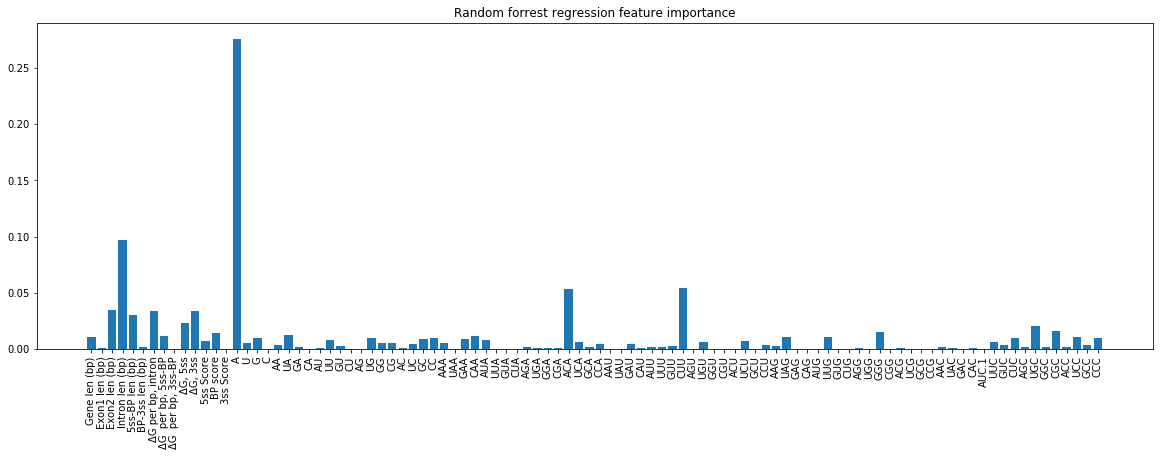

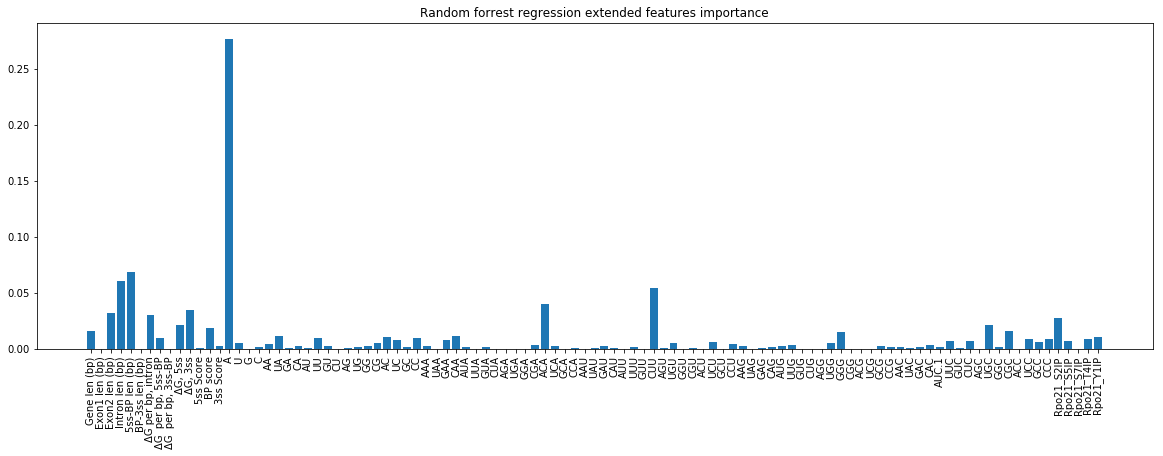

In [113]:
rfr1 = RandomForestRegressor(random_state=1337)
rfr2 = RandomForestRegressor(random_state=1337)

predictions_rfr1 = cross_val_predict(rfr1,X,y=y,cv=kf)
predictions_rfr2 = cross_val_predict(rfr2,X_extended,y=y_extended,cv=kf)

print('Data')
print_stats(y,predictions_rfr1)
print('\n')
print('Extended Data')
print_stats(y,predictions_rfr2)

rfr1.fit(X,y)
fig, ax1 = plt.subplots(figsize=(20,6))
xx = np.arange(len(rfr1.feature_importances_))
ax1.bar(xx, rfr1.feature_importances_)
ax1.set_xticks(xx)
ax1.set_xticklabels(gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
ax1.set_title('Random forrest regression feature importance')
fig.savefig('Features_importance.pdf')

rfr2.fit(X_extended,y_extended)
fig2, ax2 = plt.subplots(figsize=(20,6))
xx = np.arange(len(rfr2.feature_importances_))
ax2.bar(xx, rfr2.feature_importances_)
ax2.set_xticks(xx)
ax2.set_xticklabels(extended_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
ax2.set_title('Random forrest regression extended features importance')
fig2.savefig('Features_importance2.pdf')

Data
Coefficient of determination R^2: 0.3475907297995512
Mean squared error:               0.03402623186417844
Mean absolute error:              0.13501233846153857
Root mean squared error:          0.18446200656010017
Correlation Coefficient:          0.5925026929565316


Extended Data
Coefficient of determination R^2: 0.36787018382165537
Mean squared error:               0.03296856233654734
Mean absolute error:              0.13388295897435903
Root mean squared error:          0.18157247130704407
Correlation Coefficient:          0.6129165528734428


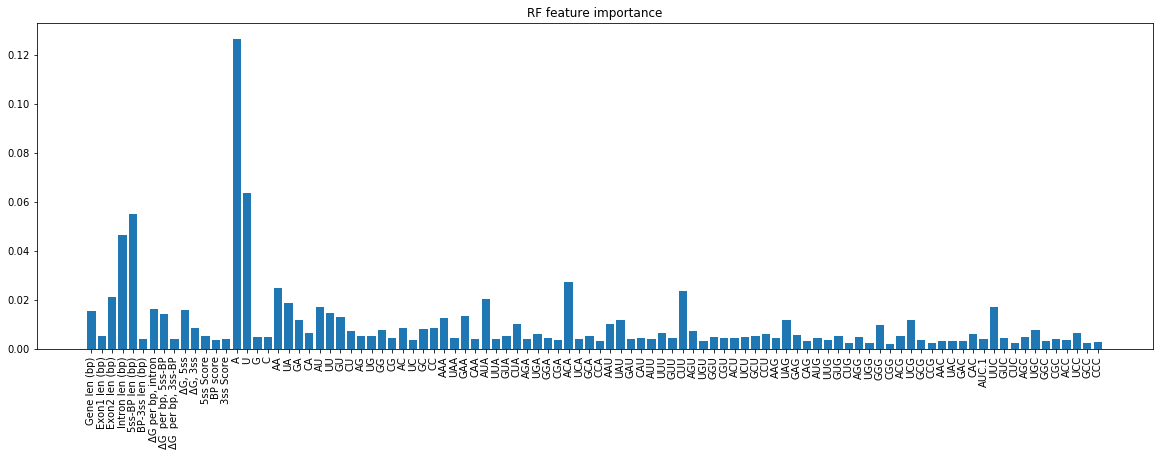

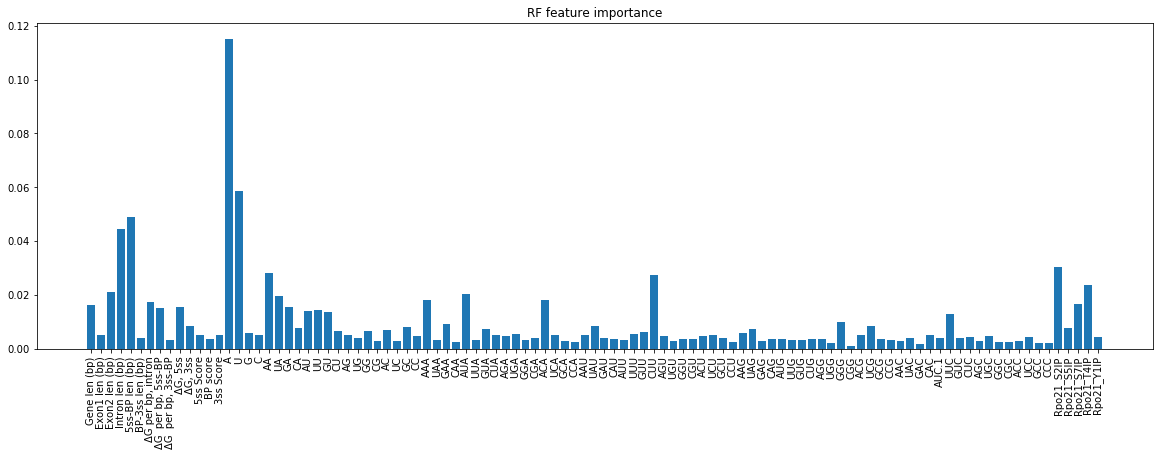

In [118]:
rfr1 = RandomForestRegressor(n_estimators=500, 
                            criterion='mse', 
                            max_features=25, 
                            max_depth=20, 
                            n_jobs=2,
                            random_state=1337)

rfr2 = RandomForestRegressor(n_estimators=500, 
                            criterion='mse', 
                            max_features=25, 
                            max_depth=20, 
                            n_jobs=2,
                            random_state=1337)

predictions_rfr1 = cross_val_predict(rfr1,X=X,y=y,cv=kf)
predictions_rfr2 = cross_val_predict(rfr2,X=X_extended,y=y_extended,cv=kf)

print('Data')
print_stats(y,predictions_rfr1)
print('\n')
print('Extended Data')
print_stats(y,predictions_rfr2)

rfr1.fit(X,y)
fig, ax1 = plt.subplots(figsize=(20,6))
xx = np.arange(len(rfr1.feature_importances_))
ax1.bar(xx, rfr1.feature_importances_)
ax1.set_xticks(xx)
ax1.set_xticklabels(gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
ax1.set_title('RF feature importance')

rfr2.fit(X_extended,y_extended)
fig2, ax2 = plt.subplots(figsize=(20,6))
xx = np.arange(len(rfr2.feature_importances_))
ax2.bar(xx, rfr2.feature_importances_)
ax2.set_xticks(xx)
ax2.set_xticklabels(extended_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
ax2.set_title('RF feature importance')

# Full Set

In [127]:
def get_best_settings(results_1,results_2):
    best_result_1 = results_1[0][0][0]
    best_result_2 = results_2[0][0][0]
    best_difference = results_2[0][0][0] - results_1[0][0][0]

    best_i_1=0
    best_j_1=0
    best_k_1=0

    best_i_2=0
    best_j_2=0
    best_k_2=0

    best_i_3=0
    best_j_3=0
    best_k_3=0
    

    mxf = [5,7,10,12,15,18,20,25,30,50,80,10]
    md = [5,7,10,12,15,18,20]
    n_est = [10,20,30,40,50,60,80,90,100,120,140,160]
    
    for i in range(len(mxf)):
        for j in range(len(md)):
            for k in range(len(n_est)):
                if best_result_1 < results_1[i][j][k]:
                    best_result_1 = results_1[i][j][k]
                    best_i_1=i
                    best_j_1=j
                    best_k_1=k
                if best_result_2 < results_2[i][j][k]:
                    best_result_2 = results_2[i][j][k]
                    best_i_2=i
                    best_j_2=j
                    best_k_2=k
                if best_difference < results_2[i][j][k] - results_1[i][j][k]:
                    best_difference = results_2[i][j][k] - results_1[i][j][k]
                    best_i_3=i
                    best_j_3=j
                    best_k_3=k

#     print('{} {} {} : {}'.format(best_i_1,best_j_1,best_k_1,best_result_1))
#     print('{} {} {} : {}'.format(best_i_2,best_j_2,best_k_2,best_result_2))
#     print('{} {} {} : {}'.format(best_i_3,best_j_3,best_k_3,best_difference))

    print('Normal best: {} | max_features: {}; max_depth: {}; n_estimators: {};'.format(best_result_1,mxf[best_i_1],md[best_j_1],n_est[best_k_1]))
    print('Extended best: {} | max_features: {}; max_depth: {}; n_estimators: {};'.format(best_result_2,mxf[best_i_2],md[best_j_2],n_est[best_k_2]))
    print('Best difference: {} | max_features: {}; max_depth: {}; n_estimators: {};'.format(best_difference,mxf[best_i_3],md[best_j_3],n_est[best_k_3]))
    
    return mxf[best_i_1],md[best_j_1],n_est[best_k_1],mxf[best_i_2],md[best_j_2],n_est[best_k_2]

In [121]:
def print_stats(true,predictions):
    print('Coefficient of determination R^2: {}'.format(r2_score(true, predictions)))
    print('Mean squared error:               {}'.format(mean_squared_error(true, predictions)))
    print('Mean absolute error:              {}'.format(mean_absolute_error(true, predictions)))
    print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(true, predictions))))
    print('Correlation Coefficient:          {}'.format(np.corrcoef(true, predictions)[0][1]))

In [150]:
def best_RFs(results1,results2):
     
    mxf1, md1, n_est1, mxf2, md2, n_est2 = get_best_settings(results1,results2)
    
    kf = KFold(n_splits=5,shuffle=True,random_state=0)
    
    rfr1 = RandomForestRegressor(n_estimators=n_est1, 
                                criterion='mse', 
                                max_features=mxf1, 
                                max_depth=md1, 
                                n_jobs=2,
                                random_state=1337)

    rfr2 = RandomForestRegressor(n_estimators=n_est2, 
                                criterion='mse', 
                                max_features=mxf2, 
                                max_depth=md2, 
                                n_jobs=2,
                                random_state=1337)

    predictions_rfr1 = cross_val_predict(rfr1,X,y=y,cv=kf)
    predictions_rfr2 = cross_val_predict(rfr2,X_extended,y=y_extended,cv=kf)

    print('Normal feature space')
    print_stats(y, predictions_rfr1)
    print('\n')
    print('Extended feature space')
    print_stats(y, predictions_rfr2)
    print('-------------------------------------------------------\n')
         
    settings = 'max_features: {}; max_depth: {}; n_estimators: {};'.format(mxf1,md1,n_est1)
          
    rfr1.fit(X,y)
    fig, ax1 = plt.subplots(figsize=(20,6))
    xx = np.arange(len(rfr1.feature_importances_))
    ax1.bar(xx, rfr1.feature_importances_)
    ax1.set_xticks(xx)
    ax1.set_xticklabels(gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
    ax1.set_title('Normal RF: {} -- {}'.format(settings,np.corrcoef(y_rp, predictions_rfr4)[0][1]))

    settings = 'max_features: {}; max_depth: {}; n_estimators: {};'.format(mxf2,md2,n_est2)
    rfr2.fit(X_extended,y_extended)
    fig2, ax2 = plt.subplots(figsize=(20,6))
    xx = np.arange(len(rfr2.feature_importances_))
    ax2.bar(xx, rfr2.feature_importances_)
    ax2.set_xticks(xx)
    ax2.set_xticklabels(extended_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
    ax2.set_title('Extended RF : {} -- {}'.format(settings,np.corrcoef(y_rp, predictions_rfr4)[0][1]))

In [151]:
def best_rp_RFs(results1,results2):
     
    mxf1, md1, n_est1, mxf2, md2, n_est2 = get_best_settings(results1,results2)
    
    kf = KFold(n_splits=5,shuffle=True,random_state=0)
    
    rfr1 = RandomForestRegressor(n_estimators=n_est1, 
                                criterion='mse', 
                                max_features=mxf1, 
                                max_depth=md1, 
                                n_jobs=2,
                                random_state=1337)

    rfr2 = RandomForestRegressor(n_estimators=n_est2, 
                                criterion='mse', 
                                max_features=mxf2, 
                                max_depth=md2, 
                                n_jobs=2,
                                random_state=1337)

    predictions_rfr1 = cross_val_predict(rfr1,X_rp,y=y_rp,cv=kf)
    predictions_rfr2 = cross_val_predict(rfr2,X_rp_extended,y=y_rp_extended,cv=kf)

    print('Normal feature space')
    print_stats(y_rp, predictions_rfr1)
    print('\n')
    print('Extended feature space')
    print_stats(y_rp_extended, predictions_rfr2)
    print('-------------------------------------------------------\n')
         
    settings = 'max_features: {}; max_depth: {}; n_estimators: {};'.format(mxf1,md1,n_est1)
          
    rfr1.fit(X_rp,y_rp)
    fig, ax1 = plt.subplots(figsize=(20,6))
    xx = np.arange(len(rfr1.feature_importances_))
    ax1.bar(xx, rfr1.feature_importances_)
    ax1.set_xticks(xx)
    ax1.set_xticklabels(gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
    ax1.set_title('Normal RF: {} -- {}'.format(settings,np.corrcoef(y_rp, predictions_rfr1)[0][1]))

    settings = 'max_features: {}; max_depth: {}; n_estimators: {};'.format(mxf2,md2,n_est2)
    rfr2.fit(X_extended_rp,y_extended_rp)
    fig2, ax2 = plt.subplots(figsize=(20,6))
    xx = np.arange(len(rfr2.feature_importances_))
    ax2.bar(xx, rfr2.feature_importances_)
    ax2.set_xticks(xx)
    ax2.set_xticklabels(extended_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
    ax2.set_title('Extended RF : {} -- {}'.format(settings,np.corrcoef(y_rp, predictions_rfr2)[0][1]))

In [152]:
def best_nrp_RFs(results1,results2):
     
    mxf1, md1, n_est1, mxf2, md2, n_est2 = get_best_settings(results1,results2)
    
    kf = KFold(n_splits=5,shuffle=True,random_state=0)
    
    rfr1 = RandomForestRegressor(n_estimators=n_est1, 
                                criterion='mse', 
                                max_features=mxf1, 
                                max_depth=md1, 
                                n_jobs=2,
                                random_state=1337)

    rfr2 = RandomForestRegressor(n_estimators=n_est2, 
                                criterion='mse', 
                                max_features=mxf2, 
                                max_depth=md2, 
                                n_jobs=2,
                                random_state=1337)

    predictions_rfr1 = cross_val_predict(rfr1,X_nrp,y=y_nrp,cv=kf)
    predictions_rfr2 = cross_val_predict(rfr2,X_nrp_extended,y=y_nrp_extended,cv=kf)

    print('Normal feature space')
    print_stats(y_nrp, predictions_rfr1)
    print('\n')
    print('Extended feature space')
    print_stats(y_nrp, predictions_rfr2)
    print('-------------------------------------------------------\n')
         
    settings = 'max_features: {}; max_depth: {}; n_estimators: {};'.format(mxf1,md1,n_est1)
          
    rfr1.fit(X_nrp,y_nrp)
    fig, ax1 = plt.subplots(figsize=(20,6))
    xx = np.arange(len(rfr1.feature_importances_))
    ax1.bar(xx, rfr1.feature_importances_)
    ax1.set_xticks(xx)
    ax1.set_xticklabels(gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
    ax1.set_title('Normal RF: {} -- {}'.format(settings,np.corrcoef(y_nrp, predictions_rfr1)[0][1]))

    settings = 'max_features: {}; max_depth: {}; n_estimators: {};'.format(mxf2,md2,n_est2)
    rfr2.fit(X_nrp_extended,y_nrp_extended)
    fig2, ax2 = plt.subplots(figsize=(20,6))
    xx = np.arange(len(rfr2.feature_importances_))
    ax2.bar(xx, rfr2.feature_importances_)
    ax2.set_xticks(xx)
    ax2.set_xticklabels(extended_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
    ax2.set_title('Extended RF : {} -- {}'.format(settings,np.corrcoef(y_nrp, predictions_rfr2)[0][1]))

In [96]:
mxf = [5,7,10,12,15,18,20,25,30,50,80,10]
md = [5,7,10,12,15,18,20]
n_est = [10,20,30,40,50,60,80,90,100,120,140,160]

results_1 = np.zeros((len(mxf),len(md),len(n_est)))
results_2 = np.zeros((len(mxf),len(md),len(n_est)))
results_1_2 = np.zeros((len(mxf),len(md),len(n_est)))
results_2_2 = np.zeros((len(mxf),len(md),len(n_est)))

f = FloatProgress(min=0, max=(len(mxf)*len(md)*len(n_est))
display(f)


i = 0
for max_features in mxf:
    j = 0
    for max_depth in md:
        k = 0
        for n_estimators in n_est:            
            
            kf = KFold(n_splits=5,shuffle=True,random_state=0)

            rfr1 = RandomForestRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            rfr2 = RandomForestRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            predictions_rfr1 = cross_val_predict(rfr1,X=X,y=y,cv=kf)
            predictions_rfr2 = cross_val_predict(rfr2,X=X_extended,y=y_extended,cv=kf)
            
            print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features,max_depth,n_estimators))

            print('Normal feature space')
            print_stats(y, predictions_rfr1)
            print('\n')
            print('Extended feature space')
            print_stats(y, predictions_rfr2)
            print('-------------------------------------------------------\n')
            
            
            results_1[i][j][k]=r2_score(y, predictions_rfr1)
            results_2[i][j][k]=r2_score(y, predictions_rfr2)
            
            results_1_2[i][j][k]=np.corrcoef(y, predictions_rfr1)[0][1]
            results_2_2[i][j][k]=np.corrcoef(y, predictions_rfr2)[0][1]
            
            f.value += 1
            
            k += 1
        j += 1
    i += 1

FloatProgress(value=0.0, max=1080.0)

KeyboardInterrupt: 

In [94]:
#get_best_settings(results_1,results_2)
get_best_settings(results_1_2,results_2_2)

Normal best: 0.6606799891294596 | max_features: 50; max_depth: 12; n_estimators: 20;
Extended best: 0.643178381615747 | max_features: 20; max_depth: 7; n_estimators: 100;
Best difference: 0.0855855290853309 | max_features: 12; max_depth: 12; n_estimators: 10;


(50, 12, 20, 20, 7, 100)

Normal best: 0.6606799891294596 | max_features: 50; max_depth: 12; n_estimators: 20;

Extended best: 0.643178381615747 | max_features: 20; max_depth: 7; n_estimators: 100;

Best difference: 0.0855855290853309 | max_features: 12; max_depth: 12; n_estimators: 10;

Normal best: 0.0 | max_features: 5; max_depth: 5; n_estimators: 10;
Extended best: 0.0 | max_features: 5; max_depth: 5; n_estimators: 10;
Best difference: 0.0 | max_features: 5; max_depth: 5; n_estimators: 10;
Normal feature space
Coefficient of determination R^2: 0.32593903458010076
Mean squared error:               0.03515547026626796
Mean absolute error:              0.14173351167018933
Root mean squared error:          0.1874979206985186
Correlation Coefficient:          0.573707468406997


Extended feature space
Coefficient of determination R^2: 0.20641257829135895
Mean squared error:               0.041389340784899226
Mean absolute error:              0.1499463155600729
Root mean squared error:          0.20344370421543947
Correlation Coefficient:          0.4705488246690762
-------------------------------------------------------



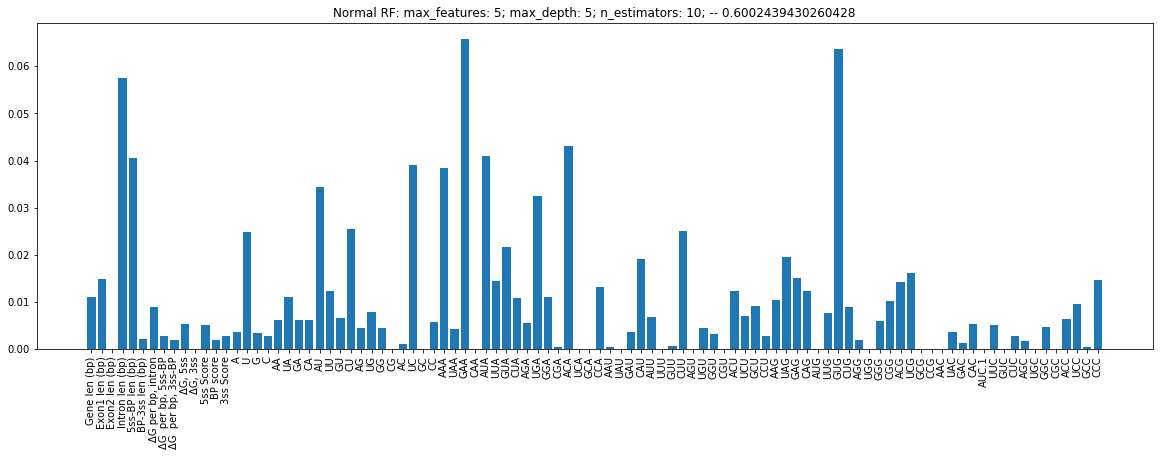

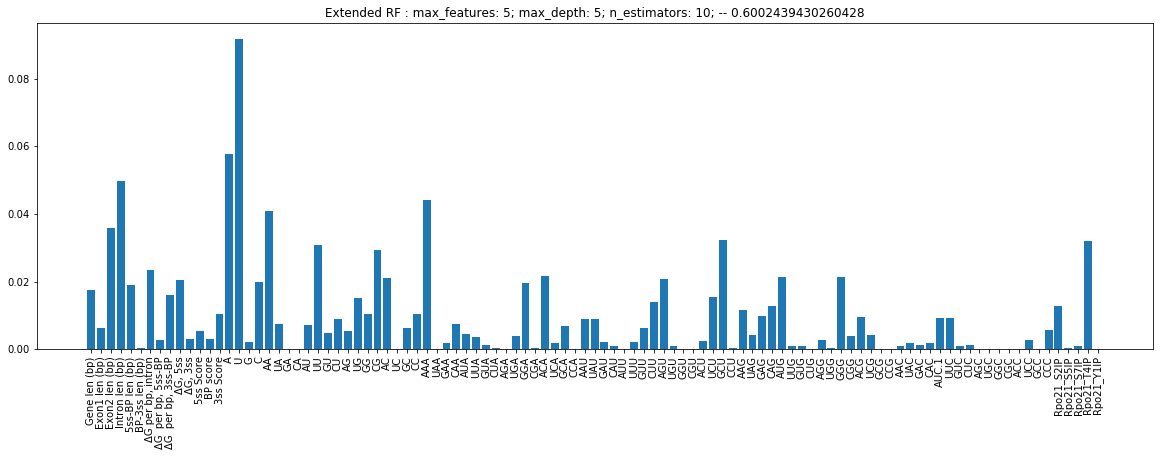

In [97]:
best_RFs(results_1_2,results_2_2)

In [ ]:
mxf = [5,7,10,12,15,18,20,25,30,50,80,10]
md = [5,7,10,12,15,18,20]
n_est = [10,20,30,40,50,60,80,90,100,120,140,160]

results_1 = np.zeros((len(mxf),len(md),len(n_est)))
results_2 = np.zeros((len(mxf),len(md),len(n_est)))
results_1_2 = np.zeros((len(mxf),len(md),len(n_est)))
results_2_2 = np.zeros((len(mxf),len(md),len(n_est)))

f = FloatProgress(min=0, max=(len(mxf)*len(md)*len(n_est))
display(f)


i = 0
for max_features in mxf:
    j = 0
    for max_depth in md:
        k = 0
        for n_estimators in n_est:            
            
            kf = KFold(n_splits=5,shuffle=True,random_state=0)

            rfr1 = RandomForestRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            rfr2 = RandomForestRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            predictions_rfr1 = cross_val_predict(rfr1,X=X_cut,y=y,cv=kf)
            predictions_rfr2 = cross_val_predict(rfr2,X=X_extended_cut,y=y_extended,cv=kf)
            
            print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features,max_depth,n_estimators))

            print('Normal feature space')
            print_stats(y, predictions_rfr1)
            print('\n')
            print('Extended feature space')
            print_stats(y, predictions_rfr2)
            print('-------------------------------------------------------\n')
            
            
            results_1[i][j][k]=r2_score(y, predictions_rfr1)
            results_2[i][j][k]=r2_score(y, predictions_rfr2)
            
            results_1_2[i][j][k]=np.corrcoef(y, predictions_rfr1)[0][1]
            results_2_2[i][j][k]=np.corrcoef(y, predictions_rfr2)[0][1]
            
            f.value += 1
            
            k += 1
        j += 1
    i += 1

In [124]:
mxf = [5,7,10,12,15,18,20,25,30,50,80,10]
md = [5,7,10,12,15,18,20]
n_est = [10,20,30,40,50,60,80,90,100,120,140,160]

results_1 = np.zeros((len(mxf),len(md),len(n_est)))
results_2 = np.zeros((len(mxf),len(md),len(n_est)))
results_1_2 = np.zeros((len(mxf),len(md),len(n_est)))
results_2_2 = np.zeros((len(mxf),len(md),len(n_est)))

f = FloatProgress(min=0, max=(len(mxf)*len(md)*len(n_est)))
display(f)


i = 0
for max_features in mxf:
    j = 0
    for max_depth in md:
        k = 0
        for n_estimators in n_est:            
            
            kf = KFold(n_splits=5,shuffle=True,random_state=0)

            rfr1 = RandomForestRegressor(n_estimators=n_estimators, 
                                        criterion='mae', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            rfr2 = RandomForestRegressor(n_estimators=n_estimators, 
                                        criterion='mae', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            predictions_rfr1 = cross_val_predict(rfr1,X=X_rp,y=y_rp,cv=kf)
            predictions_rfr2 = cross_val_predict(rfr2,X=X_extended_,y=y_extended,cv=kf)
            
            print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features,max_depth,n_estimators))

            print('Normal feature space')
            print_stats(y, predictions_rfr1)
            print('\n')
            print('Extended feature space')
            print_stats(y, predictions_rfr2)
            print('-------------------------------------------------------\n')
            
            
            results_1[i][j][k]=r2_score(y, predictions_rfr1)
            results_2[i][j][k]=r2_score(y, predictions_rfr2)
            
            results_1_2[i][j][k]=np.corrcoef(y, predictions_rfr1)[0][1]
            results_2_2[i][j][k]=np.corrcoef(y, predictions_rfr2)[0][1]
            
            f.value += 1
            
            k += 1
        j += 1
    i += 1

FloatProgress(value=0.0, max=1008.0)

max_features: 5; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.34283212317110434
Mean squared error:               0.03427441572649573
Mean absolute error:              0.13702136752136757
Root mean squared error:          0.18513350784365246
Correlation Coefficient:          0.5870962218379694


Extended feature space
Coefficient of determination R^2: 0.3483366210054172
Mean squared error:               0.03398733010683761
Mean absolute error:              0.1372619658119658
Root mean squared error:          0.1843565298730631
Correlation Coefficient:          0.5923496140388109
-------------------------------------------------------

max_features: 5; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3021151466056222
Mean squared error:               0.03639799880341881
Mean absolute error:              0.14269102564102562
Root mean squared error:          0.190782595651225
Correlation Coefficient:    

max_features: 5; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.28911834963570204
Mean squared error:               0.037075843290598286
Mean absolute error:              0.14449487179487178
Root mean squared error:          0.19255088493849692
Correlation Coefficient:          0.539555158724702


Extended feature space
Coefficient of determination R^2: 0.3345797546227268
Mean squared error:               0.03470481581196581
Mean absolute error:              0.14103504273504275
Root mean squared error:          0.18629228597010078
Correlation Coefficient:          0.5814222916445424
-------------------------------------------------------

max_features: 5; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.30281930722731865
Mean squared error:               0.03636127349358975
Mean absolute error:              0.14452179487179487
Root mean squared error:          0.1906863222509411
Correlation Coefficient:

max_features: 5; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.38103267051084266
Mean squared error:               0.03228207634615384
Mean absolute error:              0.13348931623931626
Root mean squared error:          0.17967213569764745
Correlation Coefficient:          0.6192715794073553


Extended feature space
Coefficient of determination R^2: 0.28816078563303205
Mean squared error:               0.03712578478632478
Mean absolute error:              0.1442991452991453
Root mean squared error:          0.19268052518696532
Correlation Coefficient:          0.5369661420165576
-------------------------------------------------------

max_features: 5; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3667175210627791
Mean squared error:               0.0330286791559829
Mean absolute error:              0.13730683760683765
Root mean squared error:          0.18173794088187226
Correlation Coefficient

max_features: 5; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.37049808417133956
Mean squared error:               0.032831504893162396
Mean absolute error:              0.13754914529914528
Root mean squared error:          0.18119466022254185
Correlation Coefficient:          0.6127737550029456


Extended feature space
Coefficient of determination R^2: 0.2846741398012326
Mean squared error:               0.03730762987179487
Mean absolute error:              0.14644358974358976
Root mean squared error:          0.19315183113756615
Correlation Coefficient:          0.535199933460253
-------------------------------------------------------

max_features: 5; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3438136565707691
Mean squared error:               0.03422322411324785
Mean absolute error:              0.14295897435897434
Root mean squared error:          0.18499520024381133
Correlation Coefficien

max_features: 5; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.38981393902099215
Mean squared error:               0.03182409162393162
Mean absolute error:              0.13447435897435894
Root mean squared error:          0.1783930817714959
Correlation Coefficient:          0.6328817434049658


Extended feature space
Coefficient of determination R^2: 0.32931126924121323
Mean squared error:               0.034979592264957254
Mean absolute error:              0.1440290598290598
Root mean squared error:          0.1870283194196998
Correlation Coefficient:          0.5752920675712773
-------------------------------------------------------

max_features: 5; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3602251992729767
Mean squared error:               0.03336728447115385
Mean absolute error:              0.1374938034188034
Root mean squared error:          0.18266714119171473
Correlation Coefficient:

max_features: 5; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.375335739046045
Mean squared error:               0.03257919829059829
Mean absolute error:              0.13625470085470087
Root mean squared error:          0.1804970866540463
Correlation Coefficient:          0.6178810719710244


Extended feature space
Coefficient of determination R^2: 0.3553832582740778
Mean squared error:               0.033619814615384616
Mean absolute error:              0.1413
Root mean squared error:          0.18335706862672246
Correlation Coefficient:          0.5972142695226655
-------------------------------------------------------

max_features: 5; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3616715226759847
Mean squared error:               0.033291851858974354
Mean absolute error:              0.1392679487179487
Root mean squared error:          0.18246054877417844
Correlation Coefficient:          0.6

max_features: 5; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3823683110837749
Mean squared error:               0.03221241636752136
Mean absolute error:              0.13581452991452989
Root mean squared error:          0.17947817797025176
Correlation Coefficient:          0.6243221332952766


Extended feature space
Coefficient of determination R^2: 0.3594338514062053
Mean squared error:               0.033408557008547
Mean absolute error:              0.14014273504273503
Root mean squared error:          0.1827800782594947
Correlation Coefficient:          0.6006408288755657
-------------------------------------------------------

max_features: 5; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.36282513197332844
Mean squared error:               0.033231685673076924
Mean absolute error:              0.13905897435897432
Root mean squared error:          0.182295599708487
Correlation Coefficient:  

max_features: 7; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.32152869358136116
Mean squared error:               0.03538549042735044
Mean absolute error:              0.14139145299145303
Root mean squared error:          0.18811031451611163
Correlation Coefficient:          0.5723888607340367


Extended feature space
Coefficient of determination R^2: 0.2776511038188214
Mean squared error:               0.03767391444444444
Mean absolute error:              0.1438094017094017
Root mean squared error:          0.19409769304256155
Correlation Coefficient:          0.533764674669156
-------------------------------------------------------

max_features: 7; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.33538485051425837
Mean squared error:               0.03466282625
Mean absolute error:              0.13732948717948718
Root mean squared error:          0.1861795537914945
Correlation Coefficient:        

max_features: 7; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3305908566056671
Mean squared error:               0.03491285572649574
Mean absolute error:              0.13886410256410256
Root mean squared error:          0.18684982131780523
Correlation Coefficient:          0.5760328825055921


Extended feature space
Coefficient of determination R^2: 0.23907305757843766
Mean squared error:               0.03968594217948718
Mean absolute error:              0.14778717948717948
Root mean squared error:          0.1992133082389005
Correlation Coefficient:          0.49342774597215416
-------------------------------------------------------

max_features: 7; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.35772242322765535
Mean squared error:               0.033497816089743594
Mean absolute error:              0.13429444444444447
Root mean squared error:          0.1830240860918136
Correlation Coefficient

max_features: 7; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.31710842262162653
Mean squared error:               0.03561602848290598
Mean absolute error:              0.14537478632478631
Root mean squared error:          0.188722093255946
Correlation Coefficient:          0.5631257273761886


Extended feature space
Coefficient of determination R^2: 0.21598185851697138
Mean squared error:               0.040890257521367504
Mean absolute error:              0.1524119658119658
Root mean squared error:          0.2022133959988
Correlation Coefficient:          0.4794461679413236
-------------------------------------------------------

max_features: 7; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.34630377386728306
Mean squared error:               0.03409335270833334
Mean absolute error:              0.14107884615384617
Root mean squared error:          0.18464385369768835
Correlation Coefficient:  

max_features: 7; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3429301721413298
Mean squared error:               0.034269302008547005
Mean absolute error:              0.13813418803418806
Root mean squared error:          0.18511969643597356
Correlation Coefficient:          0.5894827398403043


Extended feature space
Coefficient of determination R^2: 0.21860721574769415
Mean squared error:               0.040753332713675205
Mean absolute error:              0.15033205128205127
Root mean squared error:          0.20187454696834667
Correlation Coefficient:          0.4791054906087034
-------------------------------------------------------

max_features: 7; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3264331025845001
Mean squared error:               0.035129702280982895
Mean absolute error:              0.13911431623931625
Root mean squared error:          0.1874291927128293
Correlation Coeffici

max_features: 7; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.30800722183176665
Mean squared error:               0.03609069918803417
Mean absolute error:              0.1437282051282051
Root mean squared error:          0.18997552260234518
Correlation Coefficient:          0.5555455794365746


Extended feature space
Coefficient of determination R^2: 0.24099446825297832
Mean squared error:               0.03958573151709401
Mean absolute error:              0.15072008547008545
Root mean squared error:          0.19896163327911745
Correlation Coefficient:          0.494389640999903
-------------------------------------------------------

max_features: 7; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3085675179323609
Mean squared error:               0.03606147709401709
Mean absolute error:              0.1453230769230769
Root mean squared error:          0.18989859687216515
Correlation Coefficient:

max_features: 7; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.30864605969611014
Mean squared error:               0.036057380769230755
Mean absolute error:              0.1450094017094017
Root mean squared error:          0.18988781100752822
Correlation Coefficient:          0.5558046144656856


Extended feature space
Coefficient of determination R^2: 0.2591417068909422
Mean squared error:               0.03863926711538461
Mean absolute error:              0.14883119658119656
Root mean squared error:          0.1965687338194572
Correlation Coefficient:          0.5123383057530267
-------------------------------------------------------

max_features: 7; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3081548160091494
Mean squared error:               0.03608300145299144
Mean absolute error:              0.14586324786324784
Root mean squared error:          0.1899552617144138
Correlation Coefficient:

max_features: 7; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.30881793484335507
Mean squared error:               0.03604841666666666
Mean absolute error:              0.14497692307692303
Root mean squared error:          0.18986420585952124
Correlation Coefficient:          0.5559597999353048


Extended feature space
Coefficient of determination R^2: 0.2591417068909422
Mean squared error:               0.03863926711538461
Mean absolute error:              0.14883119658119656
Root mean squared error:          0.1965687338194572
Correlation Coefficient:          0.5123383057530267
-------------------------------------------------------

max_features: 7; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.30658191546286273
Mean squared error:               0.03616503566239315
Mean absolute error:              0.14606623931623927
Root mean squared error:          0.19017106946744858
Correlation Coefficien

max_features: 10; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2505154078833107
Mean squared error:               0.03908916944444443
Mean absolute error:              0.14197521367521368
Root mean squared error:          0.19770981119925343
Correlation Coefficient:          0.5092170656746695


Extended feature space
Coefficient of determination R^2: 0.31399251081053503
Mean squared error:               0.03577853803418805
Mean absolute error:              0.14039316239316238
Root mean squared error:          0.18915215577462513
Correlation Coefficient:          0.5604958462308798
-------------------------------------------------------

max_features: 10; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.33709506353813923
Mean squared error:               0.034573630544871795
Mean absolute error:              0.13547649572649573
Root mean squared error:          0.18593985733261117
Correlation Coeffici

max_features: 10; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2930956069954418
Mean squared error:               0.036868410491452994
Mean absolute error:              0.1426551282051282
Root mean squared error:          0.1920114853113037
Correlation Coefficient:          0.5439646130688897


Extended feature space
Coefficient of determination R^2: 0.2910216817094071
Mean squared error:               0.036976575512820506
Mean absolute error:              0.146434188034188
Root mean squared error:          0.19229294192148735
Correlation Coefficient:          0.5417861924977286
-------------------------------------------------------

max_features: 10; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3558582690351134
Mean squared error:               0.03359504055555555
Mean absolute error:              0.13562564102564104
Root mean squared error:          0.18328949930521266
Correlation Coefficient: 

max_features: 10; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.29708132578113544
Mean squared error:               0.03666053638888889
Mean absolute error:              0.14407307692307691
Root mean squared error:          0.1914694137163659
Correlation Coefficient:          0.5465402054920924


Extended feature space
Coefficient of determination R^2: 0.23128785249759265
Mean squared error:               0.04009197747863249
Mean absolute error:              0.14605299145299147
Root mean squared error:          0.20022981166308002
Correlation Coefficient:          0.4918511362161389
-------------------------------------------------------

max_features: 10; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.38713506192936253
Mean squared error:               0.03196380774572649
Mean absolute error:              0.13481495726495726
Root mean squared error:          0.1787842491544669
Correlation Coeffici

max_features: 10; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.25639741527033255
Mean squared error:               0.038782394914529915
Mean absolute error:              0.14643760683760682
Root mean squared error:          0.19693246282553295
Correlation Coefficient:          0.5074800152076145


Extended feature space
Coefficient of determination R^2: 0.2543291978517449
Mean squared error:               0.03889026224358975
Mean absolute error:              0.14781581196581195
Root mean squared error:          0.1972061414956181
Correlation Coefficient:          0.5113709686327351
-------------------------------------------------------

max_features: 10; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3426783687208319
Mean squared error:               0.03428243474893162
Mean absolute error:              0.1390190170940171
Root mean squared error:          0.18515516398127171
Correlation Coefficie

max_features: 10; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.26362596520794745
Mean squared error:               0.03840539181623932
Mean absolute error:              0.14599188034188035
Root mean squared error:          0.19597293643827282
Correlation Coefficient:          0.5157380758586945


Extended feature space
Coefficient of determination R^2: 0.2235020566368986
Mean squared error:               0.0404980435897436
Mean absolute error:              0.15013931623931623
Root mean squared error:          0.2012412571759171
Correlation Coefficient:          0.4844008408439431
-------------------------------------------------------

max_features: 10; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3472333751780975
Mean squared error:               0.03404486959935897
Mean absolute error:              0.13708311965811967
Root mean squared error:          0.1845125188147378
Correlation Coefficient

max_features: 10; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.267405711180302
Mean squared error:               0.03820826017094017
Mean absolute error:              0.14547863247863252
Root mean squared error:          0.1954693330702803
Correlation Coefficient:          0.5188397401873228


Extended feature space
Coefficient of determination R^2: 0.2305410551466911
Mean squared error:               0.0401309264957265
Mean absolute error:              0.15094017094017095
Root mean squared error:          0.20032704883696184
Correlation Coefficient:          0.4910583273714073
-------------------------------------------------------

max_features: 10; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3524167773019947
Mean squared error:               0.03377453064102563
Mean absolute error:              0.13762735042735041
Root mean squared error:          0.18377848252998943
Correlation Coefficient:

max_features: 10; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.268670596238468
Mean squared error:               0.038142290427350435
Mean absolute error:              0.14541709401709405
Root mean squared error:          0.19530051312618316
Correlation Coefficient:          0.5199931452305713


Extended feature space
Coefficient of determination R^2: 0.22817553657744205
Mean squared error:               0.040254299487179485
Mean absolute error:              0.1510307692307692
Root mean squared error:          0.20063474147609503
Correlation Coefficient:          0.48917308628179995
-------------------------------------------------------

max_features: 10; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.35539912902983195
Mean squared error:               0.03361898688034188
Mean absolute error:              0.1372854700854701
Root mean squared error:          0.1833548114458464
Correlation Coeffici

max_features: 12; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.26776216529002317
Mean squared error:               0.0381896694017094
Mean absolute error:              0.1414264957264957
Root mean squared error:          0.19542177310041325
Correlation Coefficient:          0.5263547965174564


Extended feature space
Coefficient of determination R^2: 0.22812181699033807
Mean squared error:               0.04025710121794871
Mean absolute error:              0.15231752136752136
Root mean squared error:          0.2006417235221745
Correlation Coefficient:          0.4828357159252817
-------------------------------------------------------

max_features: 12; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.35024055922252506
Mean squared error:               0.03388803071581197
Mean absolute error:              0.13350341880341884
Root mean squared error:          0.1840870194115054
Correlation Coefficient:

max_features: 12; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.31041115829839216
Mean squared error:               0.035965322521367526
Mean absolute error:              0.14176923076923076
Root mean squared error:          0.18964525441298954
Correlation Coefficient:          0.5591969431021264


Extended feature space
Coefficient of determination R^2: 0.3206098805579106
Mean squared error:               0.03543341087606838
Mean absolute error:              0.14421837606837612
Root mean squared error:          0.18823764468370396
Correlation Coefficient:          0.5668856366032033
-------------------------------------------------------

max_features: 12; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3186023478446802
Mean squared error:               0.03553811321047009
Mean absolute error:              0.1397925213675214
Root mean squared error:          0.18851555164089273
Correlation Coefficien

max_features: 12; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2879185568815841
Mean squared error:               0.03713841816239316
Mean absolute error:              0.1436547008547009
Root mean squared error:          0.1927133056184579
Correlation Coefficient:          0.5380483798436488


Extended feature space
Coefficient of determination R^2: 0.2722582056090417
Mean squared error:               0.0379551796153846
Mean absolute error:              0.15184871794871793
Root mean squared error:          0.1948208911163908
Correlation Coefficient:          0.5244170436108585
-------------------------------------------------------

max_features: 12; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.32385474922431556
Mean squared error:               0.03526417561431623
Mean absolute error:              0.13885619658119658
Root mean squared error:          0.18778758109714347
Correlation Coefficient:

max_features: 12; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3193003846563206
Mean squared error:               0.03550170728632479
Mean absolute error:              0.14728162393162392
Root mean squared error:          0.1884189674271802
Correlation Coefficient:          0.5679021381060332


Extended feature space
Coefficient of determination R^2: 0.29464169875517443
Mean squared error:               0.036787774487179487
Mean absolute error:              0.14923931623931622
Root mean squared error:          0.19180139334003674
Correlation Coefficient:          0.5428848991086022
-------------------------------------------------------

max_features: 12; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.354310883561741
Mean squared error:               0.03367574403311965
Mean absolute error:              0.13929636752136754
Root mean squared error:          0.18350952027924777
Correlation Coefficie

max_features: 12; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.30614064101713956
Mean squared error:               0.0361880502136752
Mean absolute error:              0.14547948717948722
Root mean squared error:          0.19023156997111496
Correlation Coefficient:          0.5537465889473118


Extended feature space
Coefficient of determination R^2: 0.26156515957732906
Mean squared error:               0.038512872585470086
Mean absolute error:              0.15061581196581195
Root mean squared error:          0.19624696834720806
Correlation Coefficient:          0.5145458754801217
-------------------------------------------------------

max_features: 12; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.33414091509540766
Mean squared error:               0.0347277033707265
Mean absolute error:              0.14072927350427353
Root mean squared error:          0.18635370500938933
Correlation Coeffic

max_features: 12; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.30723980536279993
Mean squared error:               0.03613072358974359
Mean absolute error:              0.1444119658119658
Root mean squared error:          0.1900808343567115
Correlation Coefficient:          0.5547774852477643


Extended feature space
Coefficient of determination R^2: 0.2588643951574937
Mean squared error:               0.03865373023504273
Mean absolute error:              0.15051495726495728
Root mean squared error:          0.196605519340233
Correlation Coefficient:          0.5112852045763893
-------------------------------------------------------

max_features: 12; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3366583762398374
Mean squared error:               0.03459640585470084
Mean absolute error:              0.13908717948717952
Root mean squared error:          0.18600109100406062
Correlation Coefficient:

max_features: 12; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.30723980536279993
Mean squared error:               0.03613072358974359
Mean absolute error:              0.1444119658119658
Root mean squared error:          0.1900808343567115
Correlation Coefficient:          0.5547774852477642


Extended feature space
Coefficient of determination R^2: 0.25850718720940724
Mean squared error:               0.03867236032051283
Mean absolute error:              0.15059188034188034
Root mean squared error:          0.19665289298790606
Correlation Coefficient:          0.5109615144822702
-------------------------------------------------------

max_features: 12; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.33008941684512383
Mean squared error:               0.034939008183760674
Mean absolute error:              0.13958846153846152
Root mean squared error:          0.18691979077604562
Correlation Coeffic

max_features: 15; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2639757650553176
Mean squared error:               0.03838714809829059
Mean absolute error:              0.14519102564102562
Root mean squared error:          0.19592638438528534
Correlation Coefficient:          0.5197783264091029


Extended feature space
Coefficient of determination R^2: 0.2857517984493597
Mean squared error:               0.03725142487179487
Mean absolute error:              0.14495982905982907
Root mean squared error:          0.1930062819490466
Correlation Coefficient:          0.5405330207890308
-------------------------------------------------------

max_features: 15; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3302344607750265
Mean squared error:               0.03493144345619657
Mean absolute error:              0.13772884615384612
Root mean squared error:          0.18689955445692366
Correlation Coefficient:

max_features: 15; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.263189530486467
Mean squared error:               0.03842815395299146
Mean absolute error:              0.14998333333333333
Root mean squared error:          0.19603100253019026
Correlation Coefficient:          0.5206362987514478


Extended feature space
Coefficient of determination R^2: 0.284451705861985
Mean squared error:               0.037319230854700854
Mean absolute error:              0.1442188034188034
Root mean squared error:          0.1931818595383657
Correlation Coefficient:          0.5344328186357594
-------------------------------------------------------

max_features: 15; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2900929741477196
Mean squared error:               0.03702501200854701
Mean absolute error:              0.14624102564102565
Root mean squared error:          0.19241884525312747
Correlation Coefficient:  

max_features: 15; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2500504371021529
Mean squared error:               0.03911341987179486
Mean absolute error:              0.14996153846153848
Root mean squared error:          0.19777113002608562
Correlation Coefficient:          0.506769582666562


Extended feature space
Coefficient of determination R^2: 0.31297629285702755
Mean squared error:               0.035831538611111116
Mean absolute error:              0.14583119658119661
Root mean squared error:          0.18929220430622892
Correlation Coefficient:          0.564555867481374
-------------------------------------------------------

max_features: 15; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2757621004097799
Mean squared error:               0.03777243491452991
Mean absolute error:              0.1447094017094017
Root mean squared error:          0.19435131827319801
Correlation Coefficien

max_features: 15; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.26364050773327796
Mean squared error:               0.03840463335470085
Mean absolute error:              0.15030897435897433
Root mean squared error:          0.19597100131065529
Correlation Coefficient:          0.5208435517640644


Extended feature space
Coefficient of determination R^2: 0.31535761704056364
Mean squared error:               0.035707341282051275
Mean absolute error:              0.14261452991452991
Root mean squared error:          0.18896386237069582
Correlation Coefficient:          0.5634587318510442
-------------------------------------------------------

max_features: 15; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.27429824862600427
Mean squared error:               0.03784878171474359
Mean absolute error:              0.14755747863247867
Root mean squared error:          0.19454763353673463
Correlation Coeff

max_features: 15; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.24366674045047576
Mean squared error:               0.03944635987179487
Mean absolute error:              0.14963760683760685
Root mean squared error:          0.19861107691112012
Correlation Coefficient:          0.5025527120556252


Extended feature space
Coefficient of determination R^2: 0.30377904568494674
Mean squared error:               0.036311218589743594
Mean absolute error:              0.14515470085470086
Root mean squared error:          0.19055502772098035
Correlation Coefficient:          0.5529840682476272
-------------------------------------------------------

max_features: 15; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.26588133641817724
Mean squared error:               0.0382877635309829
Mean absolute error:              0.1461596153846154
Root mean squared error:          0.19567259269244353
Correlation Coeffic

max_features: 15; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.26227248652500623
Mean squared error:               0.038475982136752136
Mean absolute error:              0.14848632478632479
Root mean squared error:          0.19615295597250665
Correlation Coefficient:          0.5177311992267771


Extended feature space
Coefficient of determination R^2: 0.29519994474317157
Mean squared error:               0.03675865931623932
Mean absolute error:              0.14701709401709406
Root mean squared error:          0.19172547904814144
Correlation Coefficient:          0.5464405617673549
-------------------------------------------------------

max_features: 15; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2749372045848636
Mean squared error:               0.03781545713675213
Mean absolute error:              0.1460094017094017
Root mean squared error:          0.19446196835564564
Correlation Coeffic

max_features: 15; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.26227248652500623
Mean squared error:               0.038475982136752136
Mean absolute error:              0.14848632478632479
Root mean squared error:          0.19615295597250665
Correlation Coefficient:          0.5177311992267772


Extended feature space
Coefficient of determination R^2: 0.29519994474317157
Mean squared error:               0.03675865931623932
Mean absolute error:              0.14701709401709406
Root mean squared error:          0.19172547904814144
Correlation Coefficient:          0.5464405617673547
-------------------------------------------------------

max_features: 15; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2749372045848636
Mean squared error:               0.03781545713675213
Mean absolute error:              0.14600940170940166
Root mean squared error:          0.19446196835564564
Correlation Coeffi

max_features: 18; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3464981940052533
Mean squared error:               0.034083212777777774
Mean absolute error:              0.13721880341880344
Root mean squared error:          0.18461639357808335
Correlation Coefficient:          0.5963575494440662


Extended feature space
Coefficient of determination R^2: 0.2746045385822039
Mean squared error:               0.03783280724358974
Mean absolute error:              0.1354064102564103
Root mean squared error:          0.19450657377988473
Correlation Coefficient:          0.5279779461085592
-------------------------------------------------------

max_features: 18; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.35101393890120025
Mean squared error:               0.033847695304487176
Mean absolute error:              0.13710149572649571
Root mean squared error:          0.18397743150856077
Correlation Coefficie

max_features: 18; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.23568056697783002
Mean squared error:               0.03986287662393162
Mean absolute error:              0.1507376068376068
Root mean squared error:          0.19965689726110547
Correlation Coefficient:          0.5059311683182461


Extended feature space
Coefficient of determination R^2: 0.17627127419548017
Mean squared error:               0.04296135247863248
Mean absolute error:              0.15210940170940174
Root mean squared error:          0.20727120513624772
Correlation Coefficient:          0.43974015536597005
-------------------------------------------------------

max_features: 18; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.31953587905009107
Mean squared error:               0.03548942513888889
Mean absolute error:              0.1434059829059829
Root mean squared error:          0.18838637195638355
Correlation Coefficie

max_features: 18; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2629518726994976
Mean squared error:               0.03844054893162392
Mean absolute error:              0.1472333333333333
Root mean squared error:          0.19606261482399934
Correlation Coefficient:          0.5248219272995388


Extended feature space
Coefficient of determination R^2: 0.19501075037659155
Mean squared error:               0.041984000085470076
Mean absolute error:              0.14849743589743591
Root mean squared error:          0.20489997580641653
Correlation Coefficient:          0.46954805186327103
-------------------------------------------------------

max_features: 18; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.34096434041446444
Mean squared error:               0.034371829439102566
Mean absolute error:              0.1392613247863248
Root mean squared error:          0.18539641161333886
Correlation Coeffi

max_features: 18; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.23216507699589062
Mean squared error:               0.04004622606837608
Mean absolute error:              0.1484923076923077
Root mean squared error:          0.20011553180194705
Correlation Coefficient:          0.4997388363950111


Extended feature space
Coefficient of determination R^2: 0.23273527459953303
Mean squared error:               0.04001648756410257
Mean absolute error:              0.1433128205128205
Root mean squared error:          0.20004121466363517
Correlation Coefficient:          0.49301600477687585
-------------------------------------------------------

max_features: 18; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.31293308501332195
Mean squared error:               0.03583379210470085
Mean absolute error:              0.14070598290598293
Root mean squared error:          0.18929815663312954
Correlation Coeffic

max_features: 18; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.19184269343537252
Mean squared error:               0.04214922925213676
Mean absolute error:              0.15266196581196578
Root mean squared error:          0.20530277458460408
Correlation Coefficient:          0.47216400737999586


Extended feature space
Coefficient of determination R^2: 0.2395111941719663
Mean squared error:               0.03966309128205127
Mean absolute error:              0.14286837606837607
Root mean squared error:          0.1991559471420607
Correlation Coefficient:          0.4976494365769965
-------------------------------------------------------

max_features: 18; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2990827738101599
Mean squared error:               0.03655615139957265
Mean absolute error:              0.14256923076923075
Root mean squared error:          0.1911966301993125
Correlation Coefficie

max_features: 18; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.22023454096577288
Mean squared error:               0.040668460000000003
Mean absolute error:              0.15018461538461536
Root mean squared error:          0.2016642258805463
Correlation Coefficient:          0.4934380447638714


Extended feature space
Coefficient of determination R^2: 0.21019796278347347
Mean squared error:               0.04119191506410256
Mean absolute error:              0.143341452991453
Root mean squared error:          0.20295791451456768
Correlation Coefficient:          0.47691195717793633
-------------------------------------------------------

max_features: 18; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3066841368669848
Mean squared error:               0.036159704332264946
Mean absolute error:              0.14184465811965813
Root mean squared error:          0.19015705175529238
Correlation Coeffic

max_features: 18; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.22251228816763757
Mean squared error:               0.0405496647008547
Mean absolute error:              0.14998034188034187
Root mean squared error:          0.20136947311063488
Correlation Coefficient:          0.4949727421488218


Extended feature space
Coefficient of determination R^2: 0.2111743100619724
Mean squared error:               0.041140993931623925
Mean absolute error:              0.14329487179487183
Root mean squared error:          0.20283242820521555
Correlation Coefficient:          0.4774651937076719
-------------------------------------------------------

max_features: 18; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.30766497132738246
Mean squared error:               0.03610854917200854
Mean absolute error:              0.14173397435897436
Root mean squared error:          0.19002249648925398
Correlation Coeffic

max_features: 20; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.1881487772869177
Mean squared error:               0.04234188446581197
Mean absolute error:              0.15278247863247868
Root mean squared error:          0.2057714374392422
Correlation Coefficient:          0.4535888325659494


Extended feature space
Coefficient of determination R^2: 0.30626852559883266
Mean squared error:               0.03618138042735042
Mean absolute error:              0.142174358974359
Root mean squared error:          0.19021403846023147
Correlation Coefficient:          0.553679770314115
-------------------------------------------------------

max_features: 20; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3156497408784972
Mean squared error:               0.03569210564102562
Mean absolute error:              0.14292991452991452
Root mean squared error:          0.18892354443272977
Correlation Coefficient:  

max_features: 20; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2478318076255981
Mean squared error:               0.0392291319017094
Mean absolute error:              0.15331666666666663
Root mean squared error:          0.19806345423047989
Correlation Coefficient:          0.5025379429960645


Extended feature space
Coefficient of determination R^2: 0.21015683393584572
Mean squared error:               0.041194060128205125
Mean absolute error:              0.1460376068376068
Root mean squared error:          0.20296319895046275
Correlation Coefficient:          0.47481476052555643
-------------------------------------------------------

max_features: 20; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.31663238639459756
Mean squared error:               0.03564085602564102
Mean absolute error:              0.14299273504273505
Root mean squared error:          0.1887878598470808
Correlation Coefficien

max_features: 20; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2745344094907314
Mean squared error:               0.03783646480769231
Mean absolute error:              0.1437286324786325
Root mean squared error:          0.19451597571328766
Correlation Coefficient:          0.5278330390408832


Extended feature space
Coefficient of determination R^2: 0.2520713409209605
Mean squared error:               0.039008020170940176
Mean absolute error:              0.1459547008547009
Root mean squared error:          0.19750448139457538
Correlation Coefficient:          0.5095299739412477
-------------------------------------------------------

max_features: 20; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.34578722753414315
Mean squared error:               0.0341202930448718
Mean absolute error:              0.13911581196581196
Root mean squared error:          0.18471679145348913
Correlation Coefficien

max_features: 20; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.23776516727062635
Mean squared error:               0.039754154850427346
Mean absolute error:              0.15003376068376068
Root mean squared error:          0.19938443984029283
Correlation Coefficient:          0.4949981528260767


Extended feature space
Coefficient of determination R^2: 0.24587134156862844
Mean squared error:               0.03933137948717949
Mean absolute error:              0.14856068376068374
Root mean squared error:          0.19832140451090874
Correlation Coefficient:          0.5045778268748551
-------------------------------------------------------

max_features: 20; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.30672821490236857
Mean squared error:               0.03615740545405982
Mean absolute error:              0.14580235042735043
Root mean squared error:          0.190151006976192
Correlation Coeffic

max_features: 20; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2654008866518828
Mean squared error:               0.03831282126068377
Mean absolute error:              0.1478183760683761
Root mean squared error:          0.1957366119577116
Correlation Coefficient:          0.5176333484351788


Extended feature space
Coefficient of determination R^2: 0.25179548688148135
Mean squared error:               0.03902240726495725
Mean absolute error:              0.14814786324786325
Root mean squared error:          0.1975409002332359
Correlation Coefficient:          0.5073374346076237
-------------------------------------------------------

max_features: 20; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.31172768466455014
Mean squared error:               0.035896659439102564
Mean absolute error:              0.14413782051282048
Root mean squared error:          0.18946413760683725
Correlation Coefficie

max_features: 20; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.25890135618029064
Mean squared error:               0.03865180254273505
Mean absolute error:              0.148490170940171
Root mean squared error:          0.19660061684220387
Correlation Coefficient:          0.5115556143560263


Extended feature space
Coefficient of determination R^2: 0.252894971608447
Mean squared error:               0.03896506393162393
Mean absolute error:              0.14754529914529912
Root mean squared error:          0.1973957039340622
Correlation Coefficient:          0.5099225860214776
-------------------------------------------------------

max_features: 20; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3047132412104171
Mean squared error:               0.03626249587072649
Mean absolute error:              0.14452841880341882
Root mean squared error:          0.19042714058328578
Correlation Coefficient:

max_features: 20; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2649959439377998
Mean squared error:               0.038333940940170945
Mean absolute error:              0.14784358974358977
Root mean squared error:          0.19579055375622936
Correlation Coefficient:          0.5172774771612659


Extended feature space
Coefficient of determination R^2: 0.252894971608447
Mean squared error:               0.03896506393162393
Mean absolute error:              0.14754529914529912
Root mean squared error:          0.1973957039340622
Correlation Coefficient:          0.5099225860214776
-------------------------------------------------------

max_features: 20; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.30773421762906294
Mean squared error:               0.03610493764957264
Mean absolute error:              0.1442051282051282
Root mean squared error:          0.1900129933703815
Correlation Coefficient

max_features: 25; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2360352774266372
Mean squared error:               0.03984437679487179
Mean absolute error:              0.1488410256410256
Root mean squared error:          0.19961056283391365
Correlation Coefficient:          0.48848065665874996


Extended feature space
Coefficient of determination R^2: 0.32708078033033505
Mean squared error:               0.03509592282051282
Mean absolute error:              0.14166068376068378
Root mean squared error:          0.18733905844887985
Correlation Coefficient:          0.5756356719726347
-------------------------------------------------------

max_features: 25; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.31146524720676705
Mean squared error:               0.03591034679487179
Mean absolute error:              0.13962735042735042
Root mean squared error:          0.18950025539526796
Correlation Coefficie

max_features: 25; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.319042570706369
Mean squared error:               0.0355151535042735
Mean absolute error:              0.14008205128205126
Root mean squared error:          0.18845464574871457
Correlation Coefficient:          0.5651809360990866


Extended feature space
Coefficient of determination R^2: 0.321836630817782
Mean squared error:               0.03536943004273504
Mean absolute error:              0.14116923076923077
Root mean squared error:          0.18806762093123588
Correlation Coefficient:          0.5683388388069439
-------------------------------------------------------

max_features: 25; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.38611880874210525
Mean squared error:               0.03201681016025641
Mean absolute error:              0.13355940170940175
Root mean squared error:          0.1789324178572916
Correlation Coefficient:  

max_features: 25; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2656238003436987
Mean squared error:               0.03830119525641026
Mean absolute error:              0.14512222222222224
Root mean squared error:          0.19570691162146078
Correlation Coefficient:          0.5169921643087966


Extended feature space
Coefficient of determination R^2: 0.3732433758568672
Mean squared error:               0.032688324935897434
Mean absolute error:              0.13643205128205127
Root mean squared error:          0.18079912869230713
Correlation Coefficient:          0.6120635195338829
-------------------------------------------------------

max_features: 25; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3262867757978687
Mean squared error:               0.035137333915598284
Mean absolute error:              0.1363621794871795
Root mean squared error:          0.18744955032114183
Correlation Coeffici

max_features: 25; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.24662465142749324
Mean squared error:               0.0392920908119658
Mean absolute error:              0.14751367521367517
Root mean squared error:          0.198222326724226
Correlation Coefficient:          0.5035724538520943


Extended feature space
Coefficient of determination R^2: 0.33139802985449807
Mean squared error:               0.03487075782051282
Mean absolute error:              0.1390358974358974
Root mean squared error:          0.18673713562254515
Correlation Coefficient:          0.5771483279249309
-------------------------------------------------------

max_features: 25; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.32775860218779496
Mean squared error:               0.035060571201923074
Mean absolute error:              0.13739465811965812
Root mean squared error:          0.18724468270667413
Correlation Coefficie

max_features: 25; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2844720480263895
Mean squared error:               0.037318169914529915
Mean absolute error:              0.1436324786324786
Root mean squared error:          0.19317911355664183
Correlation Coefficient:          0.5339896412500547


Extended feature space
Coefficient of determination R^2: 0.310973454119128
Mean squared error:               0.03593599613247863
Mean absolute error:              0.14039957264957262
Root mean squared error:          0.18956791957627914
Correlation Coefficient:          0.5598240752101942
-------------------------------------------------------

max_features: 25; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.33881422409081074
Mean squared error:               0.034483968183760684
Mean absolute error:              0.1354397435897436
Root mean squared error:          0.18569859499673302
Correlation Coefficie

max_features: 25; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2921814710474132
Mean squared error:               0.036916087008547004
Mean absolute error:              0.14243247863247863
Root mean squared error:          0.1921355953709437
Correlation Coefficient:          0.5409875069634277


Extended feature space
Coefficient of determination R^2: 0.29256687255035463
Mean squared error:               0.036895986495726486
Mean absolute error:              0.14208034188034188
Root mean squared error:          0.19208328010455905
Correlation Coefficient:          0.5458671942476588
-------------------------------------------------------

max_features: 25; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3412016244573862
Mean squared error:               0.034359453952991455
Mean absolute error:              0.13510299145299143
Root mean squared error:          0.18536303286521683
Correlation Coeffi

max_features: 25; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2921814710474132
Mean squared error:               0.036916087008547004
Mean absolute error:              0.14243247863247863
Root mean squared error:          0.1921355953709437
Correlation Coefficient:          0.5409875069634277


Extended feature space
Coefficient of determination R^2: 0.29256687255035463
Mean squared error:               0.036895986495726486
Mean absolute error:              0.14208034188034185
Root mean squared error:          0.19208328010455905
Correlation Coefficient:          0.5458671942476588
-------------------------------------------------------

max_features: 25; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3412016244573862
Mean squared error:               0.034359453952991455
Mean absolute error:              0.13510299145299146
Root mean squared error:          0.18536303286521683
Correlation Coeffi

max_features: 30; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.27617918115062545
Mean squared error:               0.037750682179487176
Mean absolute error:              0.14296495726495728
Root mean squared error:          0.19429534780711344
Correlation Coefficient:          0.5319553461312853


Extended feature space
Coefficient of determination R^2: 0.3676338318754605
Mean squared error:               0.03298088920940171
Mean absolute error:              0.1336611111111111
Root mean squared error:          0.18160641290824978
Correlation Coefficient:          0.6064104921374778
-------------------------------------------------------

max_features: 30; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.33083600842683025
Mean squared error:               0.03490006989850427
Mean absolute error:              0.13533311965811964
Root mean squared error:          0.18681560400165792
Correlation Coefficie

max_features: 30; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.30945208989655004
Mean squared error:               0.03601534247863248
Mean absolute error:              0.1416239316239316
Root mean squared error:          0.18977708628449452
Correlation Coefficient:          0.5604363364398814


Extended feature space
Coefficient of determination R^2: 0.34535416603449953
Mean squared error:               0.03414287925213674
Mean absolute error:              0.1364611111111111
Root mean squared error:          0.18477791873526647
Correlation Coefficient:          0.5888220558307148
-------------------------------------------------------

max_features: 30; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.35594647068442353
Mean squared error:               0.03359044042200855
Mean absolute error:              0.13475192307692307
Root mean squared error:          0.18327695005648842
Correlation Coefficien

max_features: 30; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3539011555103949
Mean squared error:               0.03369711329059829
Mean absolute error:              0.1354017094017094
Root mean squared error:          0.18356773488442432
Correlation Coefficient:          0.5953009410860227


Extended feature space
Coefficient of determination R^2: 0.37731332747627166
Mean squared error:               0.03247605769230769
Mean absolute error:              0.13215726495726496
Root mean squared error:          0.1802111475250843
Correlation Coefficient:          0.6155146043245852
-------------------------------------------------------

max_features: 30; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3724701397762068
Mean squared error:               0.032728652857905986
Mean absolute error:              0.1325019230769231
Root mean squared error:          0.1809106211860044
Correlation Coefficient

max_features: 30; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.33356981278330355
Mean squared error:               0.03475748905982906
Mean absolute error:              0.138508547008547
Root mean squared error:          0.18643360496388267
Correlation Coefficient:          0.5796505391024137


Extended feature space
Coefficient of determination R^2: 0.3259270610299474
Mean squared error:               0.03515609474358974
Mean absolute error:              0.13626068376068376
Root mean squared error:          0.18749958598244887
Correlation Coefficient:          0.5742994507519894
-------------------------------------------------------

max_features: 30; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.35432145337937193
Mean squared error:               0.03367519276709402
Mean absolute error:              0.1350337606837607
Root mean squared error:          0.1835080182637642
Correlation Coefficient

max_features: 30; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3357657988399665
Mean squared error:               0.03464295799145298
Mean absolute error:              0.13856324786324783
Root mean squared error:          0.18612618835470998
Correlation Coefficient:          0.5800973046733198


Extended feature space
Coefficient of determination R^2: 0.3408589070033954
Mean squared error:               0.03437732829059829
Mean absolute error:              0.13700427350427352
Root mean squared error:          0.18541124100387843
Correlation Coefficient:          0.5870953575739667
-------------------------------------------------------

max_features: 30; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3564987589935913
Mean squared error:               0.03356163597222223
Mean absolute error:              0.13519316239316237
Root mean squared error:          0.1831983514451542
Correlation Coefficien

max_features: 30; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.332949031805973
Mean squared error:               0.03478986572649572
Mean absolute error:              0.1395034188034188
Root mean squared error:          0.1865204163798047
Correlation Coefficient:          0.5785362148905039


Extended feature space
Coefficient of determination R^2: 0.34706425696934073
Mean squared error:               0.034053689914529915
Mean absolute error:              0.13620000000000002
Root mean squared error:          0.1845364189381866
Correlation Coefficient:          0.5917919586521778
-------------------------------------------------------

max_features: 30; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.35774160841404734
Mean squared error:               0.033496815491452996
Mean absolute error:              0.13546282051282052
Root mean squared error:          0.18302135255606924
Correlation Coefficie

max_features: 30; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3342343671879614
Mean squared error:               0.03472282940170939
Mean absolute error:              0.13943931623931624
Root mean squared error:          0.18634062735138945
Correlation Coefficient:          0.5797728030208493


Extended feature space
Coefficient of determination R^2: 0.34706425696934073
Mean squared error:               0.034053689914529915
Mean absolute error:              0.13620000000000002
Root mean squared error:          0.1845364189381866
Correlation Coefficient:          0.5917919586521777
-------------------------------------------------------

max_features: 30; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.35836401874745305
Mean squared error:               0.033464353846153844
Mean absolute error:              0.13536495726495726
Root mean squared error:          0.18293264838774365
Correlation Coeffi

max_features: 50; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.378470557860784
Mean squared error:               0.03241570264957264
Mean absolute error:              0.13343418803418805
Root mean squared error:          0.18004361318739592
Correlation Coefficient:          0.6176393283166095


Extended feature space
Coefficient of determination R^2: 0.34162924541541606
Mean squared error:               0.0343371514957265
Mean absolute error:              0.13777179487179486
Root mean squared error:          0.18530286424048198
Correlation Coefficient:          0.5857934513842737
-------------------------------------------------------

max_features: 50; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.37894106617879086
Mean squared error:               0.032391163413461536
Mean absolute error:              0.13080619658119658
Root mean squared error:          0.17997545225241562
Correlation Coefficien

max_features: 50; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.41756892464489404
Mean squared error:               0.030376537735042727
Mean absolute error:              0.1291034188034188
Root mean squared error:          0.1742886620955096
Correlation Coefficient:          0.6485849616979102


Extended feature space
Coefficient of determination R^2: 0.35277025497925785
Mean squared error:               0.03375609510683761
Mean absolute error:              0.14008760683760682
Root mean squared error:          0.1837283187394845
Correlation Coefficient:          0.5968327193100833
-------------------------------------------------------

max_features: 50; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.38776010700979324
Mean squared error:               0.031931208685897425
Mean absolute error:              0.13186837606837606
Root mean squared error:          0.1786930571843725
Correlation Coefficien

max_features: 50; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.36600231547994966
Mean squared error:               0.0330659805128205
Mean absolute error:              0.13783504273504277
Root mean squared error:          0.18184053594515306
Correlation Coefficient:          0.6133126621188634


Extended feature space
Coefficient of determination R^2: 0.34215524391887187
Mean squared error:               0.03430971818376068
Mean absolute error:              0.13881752136752135
Root mean squared error:          0.18522882654641173
Correlation Coefficient:          0.5850644842584974
-------------------------------------------------------

max_features: 50; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3666429850895814
Mean squared error:               0.03303256655982906
Mean absolute error:              0.1347641025641026
Root mean squared error:          0.18174863564777882
Correlation Coefficie

max_features: 50; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3980257416423474
Mean squared error:               0.031395807243589736
Mean absolute error:              0.1349405982905983
Root mean squared error:          0.1771886205251052
Correlation Coefficient:          0.635082458112836


Extended feature space
Coefficient of determination R^2: 0.3447258233209163
Mean squared error:               0.034175650299145294
Mean absolute error:              0.13815982905982907
Root mean squared error:          0.18486657431549192
Correlation Coefficient:          0.5874382850017936
-------------------------------------------------------

max_features: 50; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3951625023167713
Mean squared error:               0.03154513872863248
Mean absolute error:              0.1315713675213675
Root mean squared error:          0.17760951193174446
Correlation Coefficient

max_features: 50; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.39809803760942464
Mean squared error:               0.031392036666666664
Mean absolute error:              0.13382820512820512
Root mean squared error:          0.1771779801969383
Correlation Coefficient:          0.6360401908923183


Extended feature space
Coefficient of determination R^2: 0.33924688388473867
Mean squared error:               0.03446140292735043
Mean absolute error:              0.1379628205128205
Root mean squared error:          0.185637827307234
Correlation Coefficient:          0.5836803683614712
-------------------------------------------------------

max_features: 50; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.39322561071104434
Mean squared error:               0.03164615679487179
Mean absolute error:              0.13252136752136753
Root mean squared error:          0.17789366710164753
Correlation Coefficie

max_features: 50; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.39809803760942464
Mean squared error:               0.031392036666666664
Mean absolute error:              0.13382820512820512
Root mean squared error:          0.1771779801969383
Correlation Coefficient:          0.6360401908923182


Extended feature space
Coefficient of determination R^2: 0.3549444358515149
Mean squared error:               0.03364270128205129
Mean absolute error:              0.13632393162393164
Root mean squared error:          0.18341946811080684
Correlation Coefficient:          0.5964184410189023
-------------------------------------------------------

max_features: 50; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.39016900180729586
Mean squared error:               0.031805573418803426
Mean absolute error:              0.13253333333333334
Root mean squared error:          0.17834117140695085
Correlation Coeffi

max_features: 50; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.39809803760942464
Mean squared error:               0.031392036666666664
Mean absolute error:              0.13382820512820512
Root mean squared error:          0.1771779801969383
Correlation Coefficient:          0.6360401908923182


Extended feature space
Coefficient of determination R^2: 0.3549444358515149
Mean squared error:               0.03364270128205129
Mean absolute error:              0.13632393162393164
Root mean squared error:          0.18341946811080684
Correlation Coefficient:          0.5964184410189024
-------------------------------------------------------

max_features: 50; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.39016900180729597
Mean squared error:               0.03180557341880342
Mean absolute error:              0.13253333333333334
Root mean squared error:          0.17834117140695083
Correlation Coeffic

max_features: 80; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3281689578915189
Mean squared error:               0.03503916920940171
Mean absolute error:              0.138167094017094
Root mean squared error:          0.18718752418203974
Correlation Coefficient:          0.5749205555430138


Extended feature space
Coefficient of determination R^2: 0.3150169685451293
Mean squared error:               0.03572510771367521
Mean absolute error:              0.138567094017094
Root mean squared error:          0.1890108666550027
Correlation Coefficient:          0.566008168383874
-------------------------------------------------------

max_features: 80; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3204207038983734
Mean squared error:               0.0354432773344017
Mean absolute error:              0.1347570512820513
Root mean squared error:          0.18826385031227238
Correlation Coefficient:       

max_features: 80; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.34573136831613605
Mean squared error:               0.034123206367521364
Mean absolute error:              0.1385965811965812
Root mean squared error:          0.18472467720237426
Correlation Coefficient:          0.589213653933931


Extended feature space
Coefficient of determination R^2: 0.3099572246941673
Mean squared error:               0.0359889973076923
Mean absolute error:              0.14536666666666667
Root mean squared error:          0.18970766275428175
Correlation Coefficient:          0.5606665459007859
-------------------------------------------------------

max_features: 80; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.33654086164715413
Mean squared error:               0.03460253479700854
Mean absolute error:              0.13454529914529914
Root mean squared error:          0.18601756582916718
Correlation Coefficient

max_features: 80; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.37118094742528984
Mean squared error:               0.03279589034188034
Mean absolute error:              0.13837179487179485
Root mean squared error:          0.1810963565118866
Correlation Coefficient:          0.6097454902912812


Extended feature space
Coefficient of determination R^2: 0.31270205916033866
Mean squared error:               0.035845841196581185
Mean absolute error:              0.14131452991452992
Root mean squared error:          0.18932997965610512
Correlation Coefficient:          0.5645147464536208
-------------------------------------------------------

max_features: 80; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3371884025549381
Mean squared error:               0.03456876247329059
Mean absolute error:              0.13477585470085468
Root mean squared error:          0.18592676642509165
Correlation Coeffic

max_features: 80; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3526340326994296
Mean squared error:               0.033763199743589746
Mean absolute error:              0.13876153846153846
Root mean squared error:          0.1837476523485123
Correlation Coefficient:          0.597282253866724


Extended feature space
Coefficient of determination R^2: 0.33000924162835166
Mean squared error:               0.03494318970085471
Mean absolute error:              0.13876068376068373
Root mean squared error:          0.1869309757660691
Correlation Coefficient:          0.5751717170473839
-------------------------------------------------------

max_features: 80; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3322690678594412
Mean squared error:               0.03482532906517095
Mean absolute error:              0.1354301282051282
Root mean squared error:          0.1866154577337337
Correlation Coefficient:

max_features: 80; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.33573150656885953
Mean squared error:               0.0346447464957265
Mean absolute error:              0.1398974358974359
Root mean squared error:          0.18613099284032872
Correlation Coefficient:          0.5850360714126688


Extended feature space
Coefficient of determination R^2: 0.3205032013674889
Mean squared error:               0.03543897470085471
Mean absolute error:              0.1402188034188034
Root mean squared error:          0.1882524228286444
Correlation Coefficient:          0.5670890699779405
-------------------------------------------------------

max_features: 80; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3305455795985577
Mean squared error:               0.034915217136752136
Mean absolute error:              0.13566153846153844
Root mean squared error:          0.18685614021688485
Correlation Coefficient

max_features: 80; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3353490548682164
Mean squared error:               0.034664693162393165
Mean absolute error:              0.1399264957264957
Root mean squared error:          0.18618456746570905
Correlation Coefficient:          0.5847581362520795


Extended feature space
Coefficient of determination R^2: 0.31935465323440804
Mean squared error:               0.035498876923076926
Mean absolute error:              0.14053504273504272
Root mean squared error:          0.18841145645389223
Correlation Coefficient:          0.5660626712371021
-------------------------------------------------------

max_features: 80; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.331204542898776
Mean squared error:               0.034880849081196576
Mean absolute error:              0.1354653846153846
Root mean squared error:          0.1867641536301776
Correlation Coefficie

max_features: 80; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3353490548682164
Mean squared error:               0.034664693162393165
Mean absolute error:              0.1399264957264957
Root mean squared error:          0.18618456746570905
Correlation Coefficient:          0.5847581362520795


Extended feature space
Coefficient of determination R^2: 0.31935465323440804
Mean squared error:               0.035498876923076926
Mean absolute error:              0.14053504273504272
Root mean squared error:          0.18841145645389223
Correlation Coefficient:          0.5660626712371022
-------------------------------------------------------

max_features: 80; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.331204542898776
Mean squared error:               0.034880849081196576
Mean absolute error:              0.13546538461538457
Root mean squared error:          0.1867641536301776
Correlation Coeffici

max_features: 10; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2505154078833107
Mean squared error:               0.03908916944444443
Mean absolute error:              0.14197521367521368
Root mean squared error:          0.19770981119925343
Correlation Coefficient:          0.5092170656746695


Extended feature space
Coefficient of determination R^2: 0.31399251081053503
Mean squared error:               0.03577853803418805
Mean absolute error:              0.1403931623931624
Root mean squared error:          0.18915215577462513
Correlation Coefficient:          0.5604958462308797
-------------------------------------------------------

max_features: 10; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.33709506353813923
Mean squared error:               0.034573630544871795
Mean absolute error:              0.13547649572649573
Root mean squared error:          0.18593985733261117
Correlation Coefficie

max_features: 10; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2930956069954418
Mean squared error:               0.036868410491452994
Mean absolute error:              0.1426551282051282
Root mean squared error:          0.1920114853113037
Correlation Coefficient:          0.5439646130688897


Extended feature space
Coefficient of determination R^2: 0.2910216817094071
Mean squared error:               0.036976575512820506
Mean absolute error:              0.146434188034188
Root mean squared error:          0.19229294192148735
Correlation Coefficient:          0.5417861924977285
-------------------------------------------------------

max_features: 10; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.35585826903511353
Mean squared error:               0.03359504055555555
Mean absolute error:              0.135625641025641
Root mean squared error:          0.18328949930521266
Correlation Coefficient:  

max_features: 10; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.29708132578113544
Mean squared error:               0.03666053638888889
Mean absolute error:              0.14407307692307691
Root mean squared error:          0.1914694137163659
Correlation Coefficient:          0.5465402054920925


Extended feature space
Coefficient of determination R^2: 0.23128785249759265
Mean squared error:               0.04009197747863249
Mean absolute error:              0.14605299145299147
Root mean squared error:          0.20022981166308002
Correlation Coefficient:          0.4918511362161389
-------------------------------------------------------

max_features: 10; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3871350619293624
Mean squared error:               0.0319638077457265
Mean absolute error:              0.13481495726495726
Root mean squared error:          0.1787842491544669
Correlation Coefficien

max_features: 10; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.25639741527033255
Mean squared error:               0.038782394914529915
Mean absolute error:              0.14643760683760682
Root mean squared error:          0.19693246282553295
Correlation Coefficient:          0.5074800152076145


Extended feature space
Coefficient of determination R^2: 0.2543291978517449
Mean squared error:               0.03889026224358975
Mean absolute error:              0.14781581196581195
Root mean squared error:          0.1972061414956181
Correlation Coefficient:          0.5113709686327351
-------------------------------------------------------

max_features: 10; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3426783687208319
Mean squared error:               0.03428243474893162
Mean absolute error:              0.1390190170940171
Root mean squared error:          0.18515516398127171
Correlation Coefficie

max_features: 10; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.26362596520794745
Mean squared error:               0.03840539181623932
Mean absolute error:              0.14599188034188035
Root mean squared error:          0.19597293643827282
Correlation Coefficient:          0.5157380758586944


Extended feature space
Coefficient of determination R^2: 0.22350205663689882
Mean squared error:               0.04049804358974359
Mean absolute error:              0.15013931623931623
Root mean squared error:          0.20124125717591707
Correlation Coefficient:          0.4844008408439431
-------------------------------------------------------

max_features: 10; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3472333751780975
Mean squared error:               0.03404486959935897
Mean absolute error:              0.13708311965811965
Root mean squared error:          0.1845125188147378
Correlation Coeffici

max_features: 10; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.267405711180302
Mean squared error:               0.03820826017094017
Mean absolute error:              0.14547863247863252
Root mean squared error:          0.1954693330702803
Correlation Coefficient:          0.5188397401873228


Extended feature space
Coefficient of determination R^2: 0.2305410551466911
Mean squared error:               0.0401309264957265
Mean absolute error:              0.15094017094017095
Root mean squared error:          0.20032704883696184
Correlation Coefficient:          0.4910583273714073
-------------------------------------------------------

max_features: 10; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3524167773019946
Mean squared error:               0.03377453064102564
Mean absolute error:              0.13762735042735041
Root mean squared error:          0.18377848252998946
Correlation Coefficient:

max_features: 10; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.268670596238468
Mean squared error:               0.038142290427350435
Mean absolute error:              0.14541709401709405
Root mean squared error:          0.19530051312618316
Correlation Coefficient:          0.5199931452305714


Extended feature space
Coefficient of determination R^2: 0.22817553657744205
Mean squared error:               0.040254299487179485
Mean absolute error:              0.1510307692307692
Root mean squared error:          0.20063474147609503
Correlation Coefficient:          0.48917308628180006
-------------------------------------------------------

max_features: 10; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.35539912902983195
Mean squared error:               0.03361898688034187
Mean absolute error:              0.1372854700854701
Root mean squared error:          0.18335481144584637
Correlation Coeffic

Normal best: 0.6485849616979102 | max_features: 50; max_depth: 7; n_estimators: 10;
Extended best: 0.6406053037479402 | max_features: 5; max_depth: 20; n_estimators: 50;
Best difference: 0.10009093774816558 | max_features: 20; max_depth: 5; n_estimators: 10;
Normal feature space
Coefficient of determination R^2: 0.41756892464489404
Mean squared error:               0.03037653773504273
Mean absolute error:              0.1291034188034188
Root mean squared error:          0.1742886620955096
Correlation Coefficient:          0.6485849616979102


Extended feature space
Coefficient of determination R^2: 0.38691168381575647
Mean squared error:               0.03197545797179487
Mean absolute error:              0.13664094017094014
Root mean squared error:          0.1788168279882933
Correlation Coefficient:          0.6406053037479402
-------------------------------------------------------



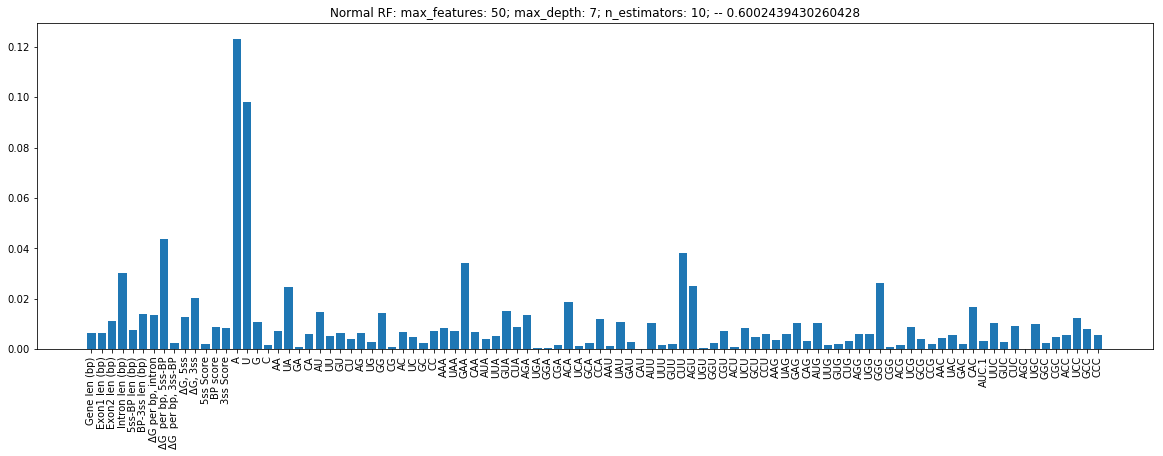

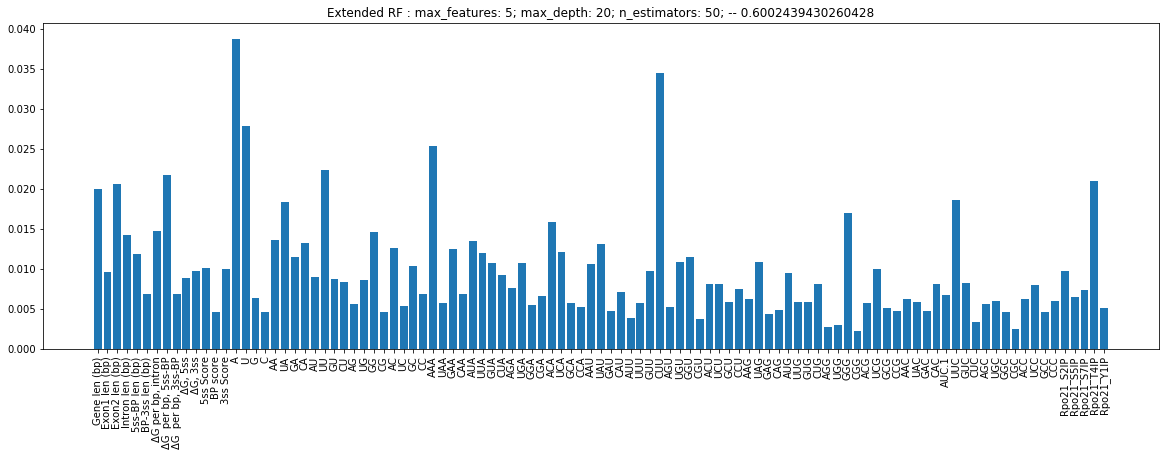

In [132]:
best_RFs(results_1_2,results_2_2)

## MAE Results

Normal best: 0.6485849616979102 | max_features: 50; max_depth: 7; n_estimators: 10;

Extended best: 0.6406053037479402 | max_features: 5; max_depth: 20; n_estimators: 50;

Best difference: 0.10009093774816558 | max_features: 20; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.41756892464489404
Mean squared error:               0.03037653773504273
Mean absolute error:              0.1291034188034188
Root mean squared error:          0.1742886620955096
Correlation Coefficient:          0.6485849616979102


Extended feature space
Coefficient of determination R^2: 0.38691168381575647
Mean squared error:               0.03197545797179487
Mean absolute error:              0.13664094017094014
Root mean squared error:          0.1788168279882933
Correlation Coefficient:          0.6406053037479402


# RP Genes

In [138]:
mxf = [5,7,10,12,15,18,20,25,30,50,80,10]
md = [5,7,10,12,15,18,20]
n_est = [10,20,30,40,50,60,80,90,100,120,140,160]

results_1 = np.zeros((len(mxf),len(md),len(n_est)))
results_2 = np.zeros((len(mxf),len(md),len(n_est)))
results_1_2 = np.zeros((len(mxf),len(md),len(n_est)))
results_2_2 = np.zeros((len(mxf),len(md),len(n_est)))

f = FloatProgress(min=0, max=(len(mxf)*len(md)*len(n_est)))
display(f)

i = 0
for max_features in mxf:
    j = 0
    for max_depth in md:
        k = 0
        for n_estimators in n_est:            
            
            kf = KFold(n_splits=5,shuffle=True,random_state=0)

            rfr1 = RandomForestRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            rfr2 = RandomForestRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            predictions_rfr1 = cross_val_predict(rfr1,X=X_rp,y=y_rp,cv=kf)
            predictions_rfr2 = cross_val_predict(rfr2,X=X_rp_extended,y=y_rp_extended,cv=kf)
            
            print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features,max_depth,n_estimators))

#             print('Normal feature space')
#             print_stats(y, predictions_rfr1)
#             print('\n')
#             print('Extended feature space')
#             print_stats(y, predictions_rfr2)
#             print('-------------------------------------------------------\n')
            
            
            results_1[i][j][k]=r2_score(y_rp, predictions_rfr1)
            results_2[i][j][k]=r2_score(y_rp, predictions_rfr2)
            
            results_1_2[i][j][k]=np.corrcoef(y_rp, predictions_rfr1)[0][1]
            results_2_2[i][j][k]=np.corrcoef(y_rp, predictions_rfr2)[0][1]
            
            f.value += 1
            
            k += 1
        j += 1
    i += 1

FloatProgress(value=0.0, max=1008.0)

max_features: 5; max_depth: 5; n_estimators: 10;

max_features: 5; max_depth: 5; n_estimators: 20;

max_features: 5; max_depth: 5; n_estimators: 30;

max_features: 5; max_depth: 5; n_estimators: 40;

max_features: 5; max_depth: 5; n_estimators: 50;

max_features: 5; max_depth: 5; n_estimators: 60;

max_features: 5; max_depth: 5; n_estimators: 80;

max_features: 5; max_depth: 5; n_estimators: 90;

max_features: 5; max_depth: 5; n_estimators: 100;

max_features: 5; max_depth: 5; n_estimators: 120;

max_features: 5; max_depth: 5; n_estimators: 140;

max_features: 5; max_depth: 5; n_estimators: 160;

max_features: 5; max_depth: 7; n_estimators: 10;

max_features: 5; max_depth: 7; n_estimators: 20;

max_features: 5; max_depth: 7; n_estimators: 30;

max_features: 5; max_depth: 7; n_estimators: 40;

max_features: 5; max_depth: 7; n_estimators: 50;

max_features: 5; max_depth: 7; n_estimators: 60;

max_features: 5; max_depth: 7; n_estimators: 80;

max_features: 5; max_depth: 7; n_estimators: 9

max_features: 7; max_depth: 20; n_estimators: 60;

max_features: 7; max_depth: 20; n_estimators: 80;

max_features: 7; max_depth: 20; n_estimators: 90;

max_features: 7; max_depth: 20; n_estimators: 100;

max_features: 7; max_depth: 20; n_estimators: 120;

max_features: 7; max_depth: 20; n_estimators: 140;

max_features: 7; max_depth: 20; n_estimators: 160;

max_features: 10; max_depth: 5; n_estimators: 10;

max_features: 10; max_depth: 5; n_estimators: 20;

max_features: 10; max_depth: 5; n_estimators: 30;

max_features: 10; max_depth: 5; n_estimators: 40;

max_features: 10; max_depth: 5; n_estimators: 50;

max_features: 10; max_depth: 5; n_estimators: 60;

max_features: 10; max_depth: 5; n_estimators: 80;

max_features: 10; max_depth: 5; n_estimators: 90;

max_features: 10; max_depth: 5; n_estimators: 100;

max_features: 10; max_depth: 5; n_estimators: 120;

max_features: 10; max_depth: 5; n_estimators: 140;

max_features: 10; max_depth: 5; n_estimators: 160;

max_features: 10; max_d

max_features: 12; max_depth: 18; n_estimators: 90;

max_features: 12; max_depth: 18; n_estimators: 100;

max_features: 12; max_depth: 18; n_estimators: 120;

max_features: 12; max_depth: 18; n_estimators: 140;

max_features: 12; max_depth: 18; n_estimators: 160;

max_features: 12; max_depth: 20; n_estimators: 10;

max_features: 12; max_depth: 20; n_estimators: 20;

max_features: 12; max_depth: 20; n_estimators: 30;

max_features: 12; max_depth: 20; n_estimators: 40;

max_features: 12; max_depth: 20; n_estimators: 50;

max_features: 12; max_depth: 20; n_estimators: 60;

max_features: 12; max_depth: 20; n_estimators: 80;

max_features: 12; max_depth: 20; n_estimators: 90;

max_features: 12; max_depth: 20; n_estimators: 100;

max_features: 12; max_depth: 20; n_estimators: 120;

max_features: 12; max_depth: 20; n_estimators: 140;

max_features: 12; max_depth: 20; n_estimators: 160;

max_features: 15; max_depth: 5; n_estimators: 10;

max_features: 15; max_depth: 5; n_estimators: 20;

max_fe

max_features: 18; max_depth: 15; n_estimators: 120;

max_features: 18; max_depth: 15; n_estimators: 140;

max_features: 18; max_depth: 15; n_estimators: 160;

max_features: 18; max_depth: 18; n_estimators: 10;

max_features: 18; max_depth: 18; n_estimators: 20;

max_features: 18; max_depth: 18; n_estimators: 30;

max_features: 18; max_depth: 18; n_estimators: 40;

max_features: 18; max_depth: 18; n_estimators: 50;

max_features: 18; max_depth: 18; n_estimators: 60;

max_features: 18; max_depth: 18; n_estimators: 80;

max_features: 18; max_depth: 18; n_estimators: 90;

max_features: 18; max_depth: 18; n_estimators: 100;

max_features: 18; max_depth: 18; n_estimators: 120;

max_features: 18; max_depth: 18; n_estimators: 140;

max_features: 18; max_depth: 18; n_estimators: 160;

max_features: 18; max_depth: 20; n_estimators: 10;

max_features: 18; max_depth: 20; n_estimators: 20;

max_features: 18; max_depth: 20; n_estimators: 30;

max_features: 18; max_depth: 20; n_estimators: 40;

max_f

max_features: 25; max_depth: 12; n_estimators: 160;

max_features: 25; max_depth: 15; n_estimators: 10;

max_features: 25; max_depth: 15; n_estimators: 20;

max_features: 25; max_depth: 15; n_estimators: 30;

max_features: 25; max_depth: 15; n_estimators: 40;

max_features: 25; max_depth: 15; n_estimators: 50;

max_features: 25; max_depth: 15; n_estimators: 60;

max_features: 25; max_depth: 15; n_estimators: 80;

max_features: 25; max_depth: 15; n_estimators: 90;

max_features: 25; max_depth: 15; n_estimators: 100;

max_features: 25; max_depth: 15; n_estimators: 120;

max_features: 25; max_depth: 15; n_estimators: 140;

max_features: 25; max_depth: 15; n_estimators: 160;

max_features: 25; max_depth: 18; n_estimators: 10;

max_features: 25; max_depth: 18; n_estimators: 20;

max_features: 25; max_depth: 18; n_estimators: 30;

max_features: 25; max_depth: 18; n_estimators: 40;

max_features: 25; max_depth: 18; n_estimators: 50;

max_features: 25; max_depth: 18; n_estimators: 60;

max_fea

max_features: 50; max_depth: 12; n_estimators: 20;

max_features: 50; max_depth: 12; n_estimators: 30;

max_features: 50; max_depth: 12; n_estimators: 40;

max_features: 50; max_depth: 12; n_estimators: 50;

max_features: 50; max_depth: 12; n_estimators: 60;

max_features: 50; max_depth: 12; n_estimators: 80;

max_features: 50; max_depth: 12; n_estimators: 90;

max_features: 50; max_depth: 12; n_estimators: 100;

max_features: 50; max_depth: 12; n_estimators: 120;

max_features: 50; max_depth: 12; n_estimators: 140;

max_features: 50; max_depth: 12; n_estimators: 160;

max_features: 50; max_depth: 15; n_estimators: 10;

max_features: 50; max_depth: 15; n_estimators: 20;

max_features: 50; max_depth: 15; n_estimators: 30;

max_features: 50; max_depth: 15; n_estimators: 40;

max_features: 50; max_depth: 15; n_estimators: 50;

max_features: 50; max_depth: 15; n_estimators: 60;

max_features: 50; max_depth: 15; n_estimators: 80;

max_features: 50; max_depth: 15; n_estimators: 90;

max_feat

max_features: 10; max_depth: 10; n_estimators: 40;

max_features: 10; max_depth: 10; n_estimators: 50;

max_features: 10; max_depth: 10; n_estimators: 60;

max_features: 10; max_depth: 10; n_estimators: 80;

max_features: 10; max_depth: 10; n_estimators: 90;

max_features: 10; max_depth: 10; n_estimators: 100;

max_features: 10; max_depth: 10; n_estimators: 120;

max_features: 10; max_depth: 10; n_estimators: 140;

max_features: 10; max_depth: 10; n_estimators: 160;

max_features: 10; max_depth: 12; n_estimators: 10;

max_features: 10; max_depth: 12; n_estimators: 20;

max_features: 10; max_depth: 12; n_estimators: 30;

max_features: 10; max_depth: 12; n_estimators: 40;

max_features: 10; max_depth: 12; n_estimators: 50;

max_features: 10; max_depth: 12; n_estimators: 60;

max_features: 10; max_depth: 12; n_estimators: 80;

max_features: 10; max_depth: 12; n_estimators: 90;

max_features: 10; max_depth: 12; n_estimators: 100;

max_features: 10; max_depth: 12; n_estimators: 120;

max_fe

Normal best: 0.683828520812472 | max_features: 80; max_depth: 12; n_estimators: 10;
Extended best: 0.6995253307038448 | max_features: 25; max_depth: 5; n_estimators: 10;
Best difference: 0.178522036722764 | max_features: 7; max_depth: 5; n_estimators: 20;
Normal feature space
Coefficient of determination R^2: 0.3526340326994295
Mean squared error:               0.03376319974358975
Mean absolute error:              0.13876153846153846
Root mean squared error:          0.18374765234851234
Correlation Coefficient:          0.5972822538667238


Extended feature space
Coefficient of determination R^2: 0.32708078033033505
Mean squared error:               0.03509592282051282
Mean absolute error:              0.14166068376068375
Root mean squared error:          0.18733905844887985
Correlation Coefficient:          0.5756356719726347
-------------------------------------------------------



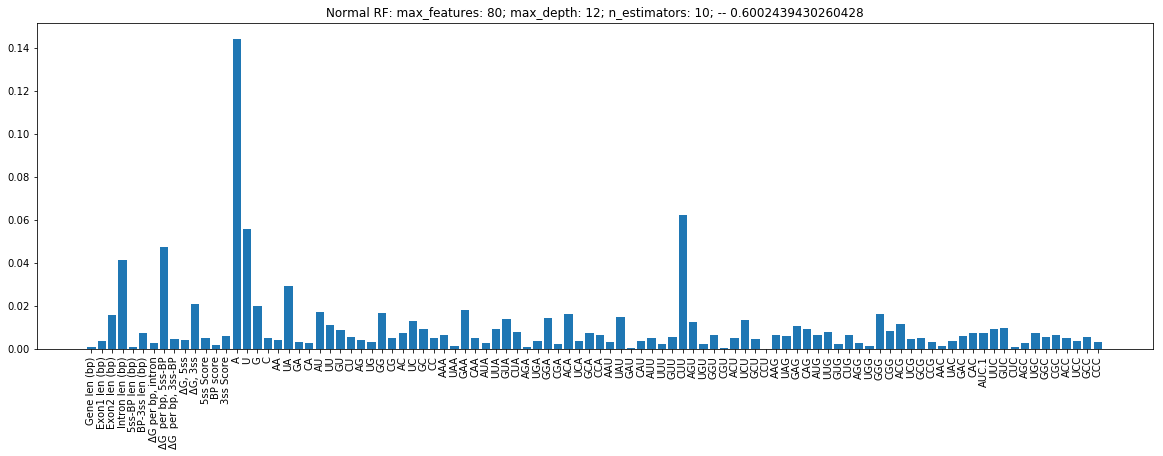

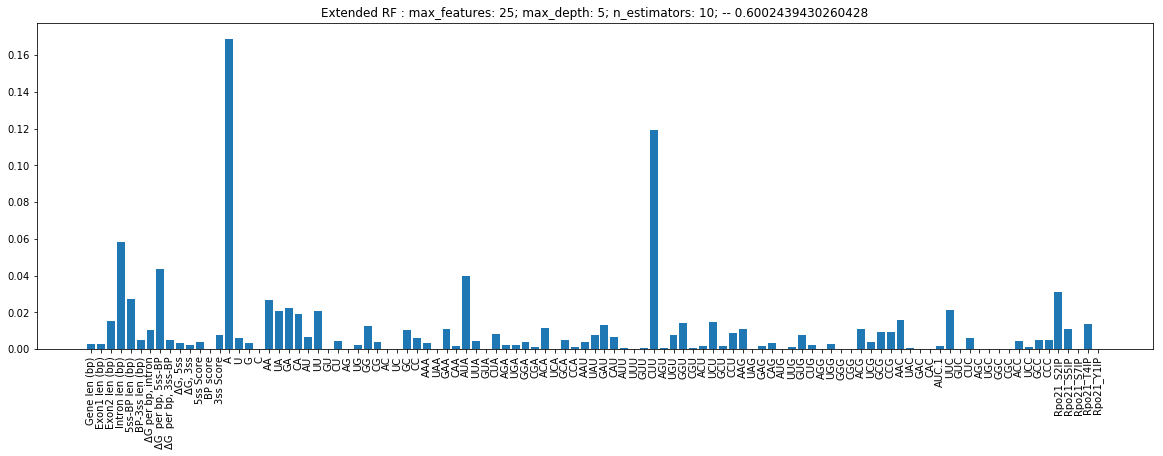

In [139]:
best_RFs(results_1_2,results_2_2)

In [ ]:
Normal best: 0.683828520812472 | max_features: 80; max_depth: 12; n_estimators: 10;
Extended best: 0.6995253307038448 | max_features: 25; max_depth: 5; n_estimators: 10;
Best difference: 0.178522036722764 | max_features: 7; max_depth: 5; n_estimators: 20;
Normal feature space
Coefficient of determination R^2: 0.3526340326994295
Mean squared error:               0.03376319974358975
Mean absolute error:              0.13876153846153846
Root mean squared error:          0.18374765234851234
Correlation Coefficient:          0.5972822538667238


Extended feature space
Coefficient of determination R^2: 0.32708078033033505
Mean squared error:               0.03509592282051282
Mean absolute error:              0.14166068376068375
Root mean squared error:          0.18733905844887985
Correlation Coefficient:          0.5756356719726347

# Non-RP Genes

In [153]:
mxf = [5,7,10,12,15,18,20,25,30,50,80,10]
md = [5,7,10,12,15,18,20]
n_est = [10,20,30,40,50,60,80,90,100,120,140,160]

results_1 = np.zeros((len(mxf),len(md),len(n_est)))
results_2 = np.zeros((len(mxf),len(md),len(n_est)))
results_1_2 = np.zeros((len(mxf),len(md),len(n_est)))
results_2_2 = np.zeros((len(mxf),len(md),len(n_est)))

f = FloatProgress(min=0, max=(len(mxf)*len(md)*len(n_est)))
display(f)

i = 0
for max_features in mxf:
    j = 0
    for max_depth in md:
        k = 0
        for n_estimators in n_est:            
            
            kf = KFold(n_splits=5,shuffle=True,random_state=0)

            rfr1 = RandomForestRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            rfr2 = RandomForestRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            predictions_rfr1 = cross_val_predict(rfr1,X=X_nrp,y=y_nrp,cv=kf)
            predictions_rfr2 = cross_val_predict(rfr2,X=X_nrp_extended,y=y_nrp_extended,cv=kf)
            
            print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features,max_depth,n_estimators))

#             print('Normal feature space')
#             print_stats(y, predictions_rfr1)
#             print('\n')
#             print('Extended feature space')
#             print_stats(y, predictions_rfr2)
#             print('-------------------------------------------------------\n')
            
            
            results_1[i][j][k]=r2_score(y_nrp, predictions_rfr1)
            results_2[i][j][k]=r2_score(y_nrp, predictions_rfr2)
            
            results_1_2[i][j][k]=np.corrcoef(y_nrp, predictions_rfr1)[0][1]
            results_2_2[i][j][k]=np.corrcoef(y_nrp, predictions_rfr2)[0][1]
            
            f.value += 1
            
            k += 1
        j += 1
    i += 1

FloatProgress(value=0.0, max=1008.0)

KeyboardInterrupt: 

Normal best: 0.0 | max_features: 5; max_depth: 5; n_estimators: 10;
Extended best: 0.0 | max_features: 5; max_depth: 5; n_estimators: 10;
Best difference: 0.0 | max_features: 5; max_depth: 5; n_estimators: 10;
Normal feature space
Coefficient of determination R^2: -0.17288754205125412
Mean squared error:               0.06861558845509945
Mean absolute error:              0.2250189466089466
Root mean squared error:          0.2619457738828772
Correlation Coefficient:          0.00026368969917265657


Extended feature space
Coefficient of determination R^2: -0.07264862214631762
Mean squared error:               0.06275146915227865
Mean absolute error:              0.20320011063011065
Root mean squared error:          0.2505024334258625
Correlation Coefficient:          0.03260708413153405
-------------------------------------------------------



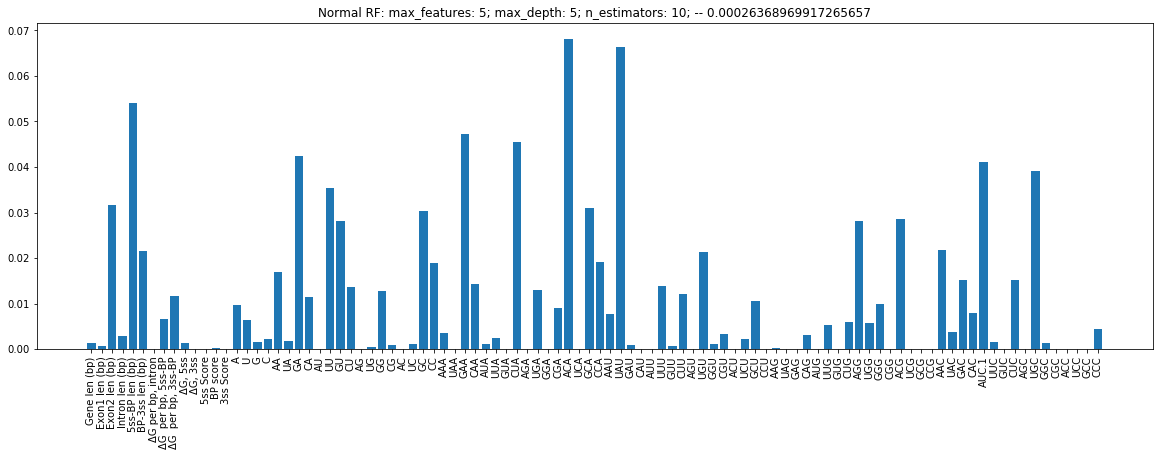

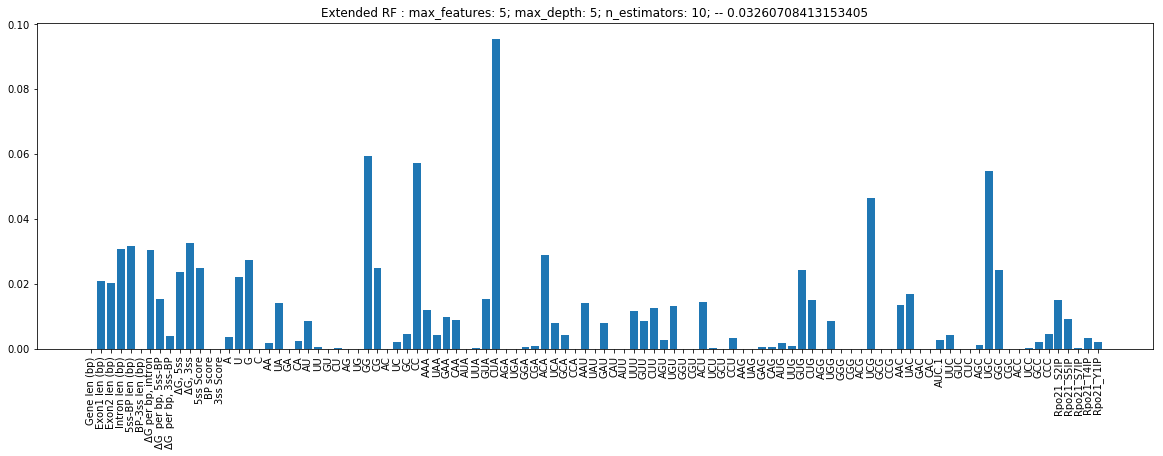

In [154]:
best_nrp_RFs(results_1_2,results_2_2)

In [ ]:
Normal best: 0.2969901764177368 | max_features: 25; max_depth: 5; n_estimators: 10;
Extended best: 0.40630448232918154 | max_features: 30; max_depth: 7; n_estimators: 20;
Best difference: 0.2582434619528223 | max_features: 30; max_depth: 7; n_estimators: 20;
Normal feature space
Coefficient of determination R^2: 0.2360352774266372
Mean squared error:               0.03984437679487179
Mean absolute error:              0.1488410256410256
Root mean squared error:          0.19961056283391365
Correlation Coefficient:          0.48848065665874996


Extended feature space
Coefficient of determination R^2: 0.38909635792549957
Mean squared error:               0.031861516874999996
Mean absolute error:              0.13109380341880345
Root mean squared error:          0.1784979464167585
Correlation Coefficient:          0.6250700537546936

FloatProgress(value=0.0, max=1080.0)

max_features: 25; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.3130916509906382
Mean squared error:               0.03582552213835246
Mean absolute error:              0.13991477005623373
Root mean squared error:          0.18927631161440267
Correlation Coefficient:          0.5597371021293195


Extended feature space
Coefficient of determination R^2: 0.3628571330676368
Mean squared error:               0.03323001666451959
Mean absolute error:              0.13294483868695406
Root mean squared error:          0.1822910218977325
Correlation Coefficient:          0.6035500707894144
-------------------------------------------------------

max_features: 25; max_depth: 10; n_estimators: 30;

Normal feature space
Coefficient of determination R^2: 0.3432284547489546
Mean squared error:               0.03425374515852712
Mean absolute error:              0.13671984654564073
Root mean squared error:          0.18507767331184796
Correlation Coefficien

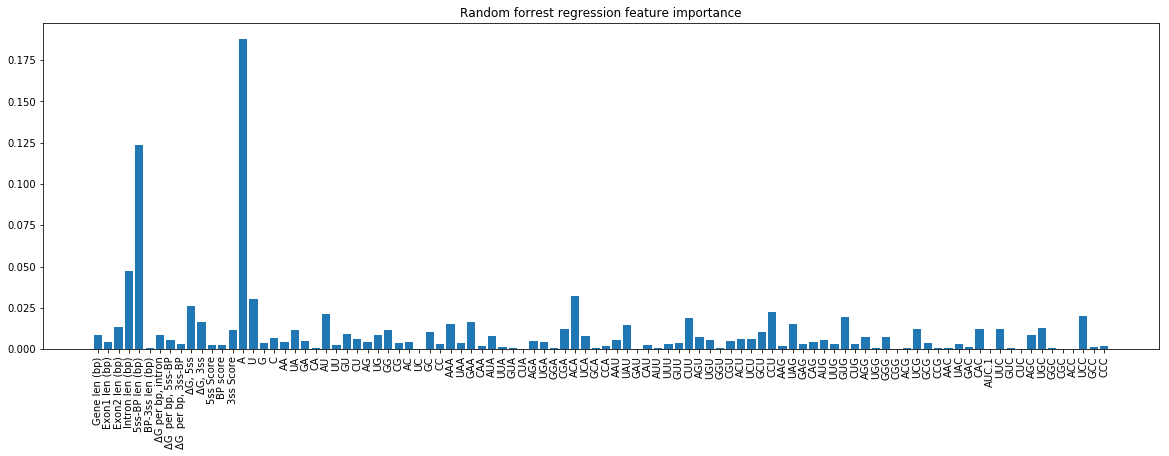

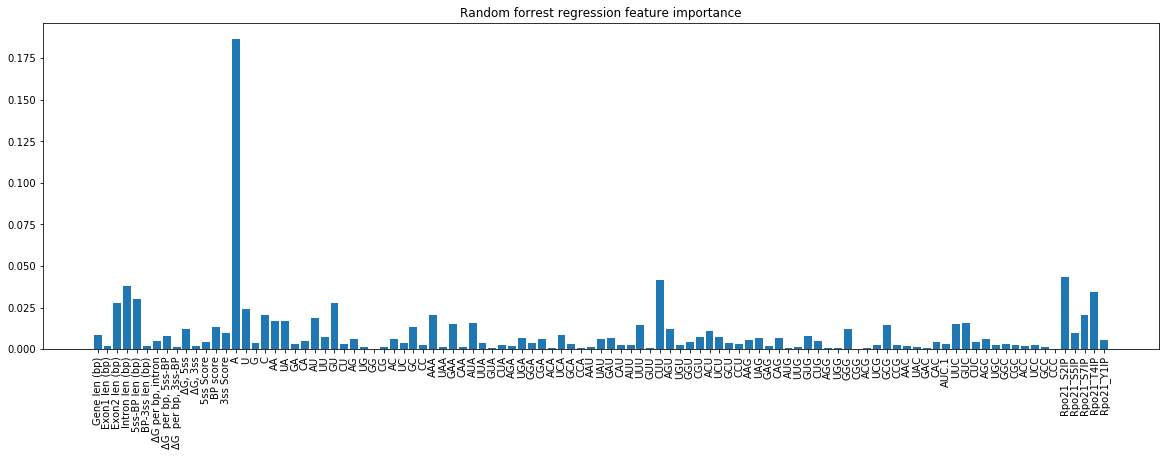

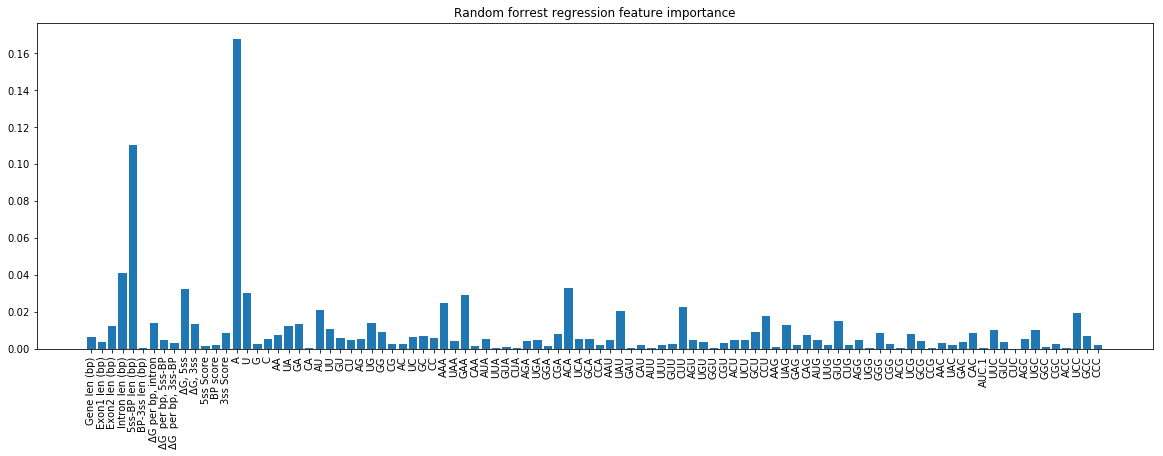

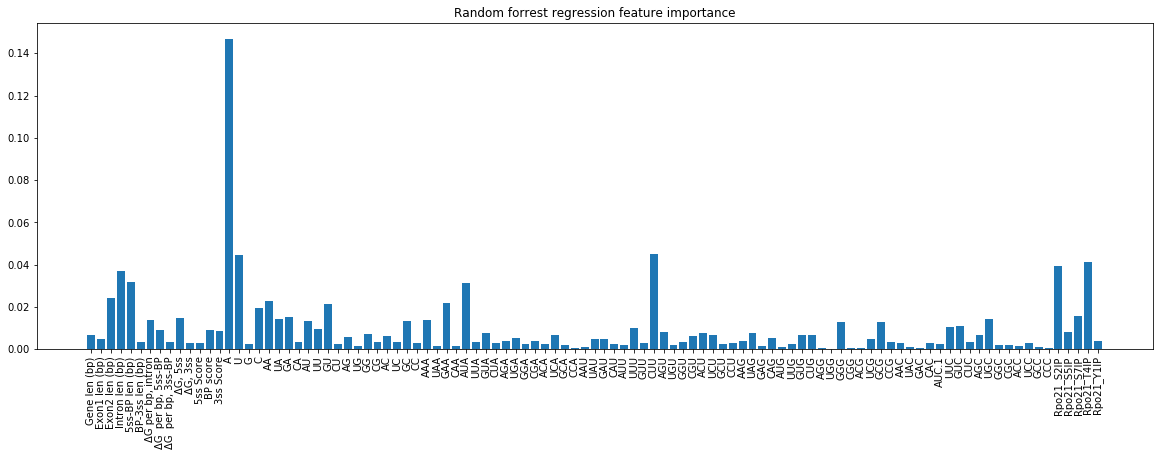

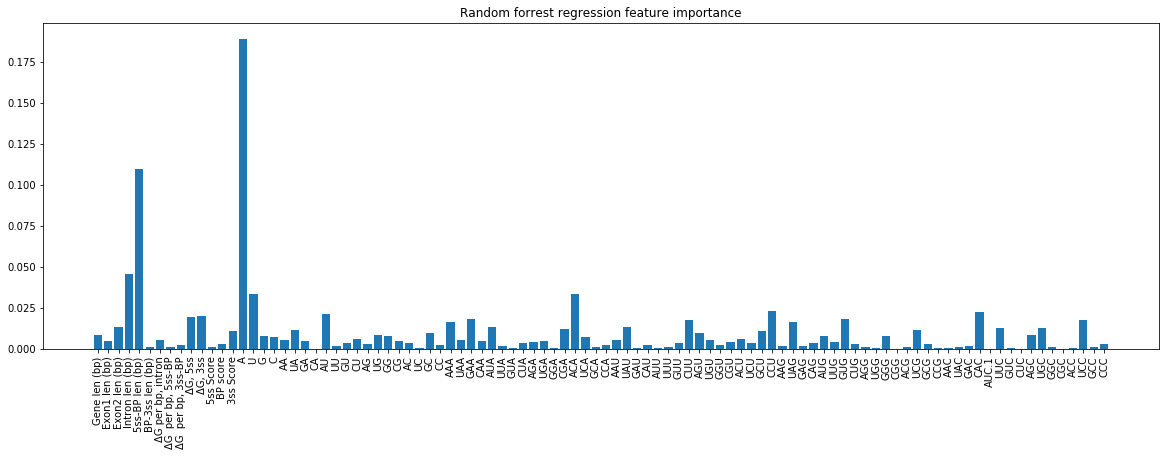

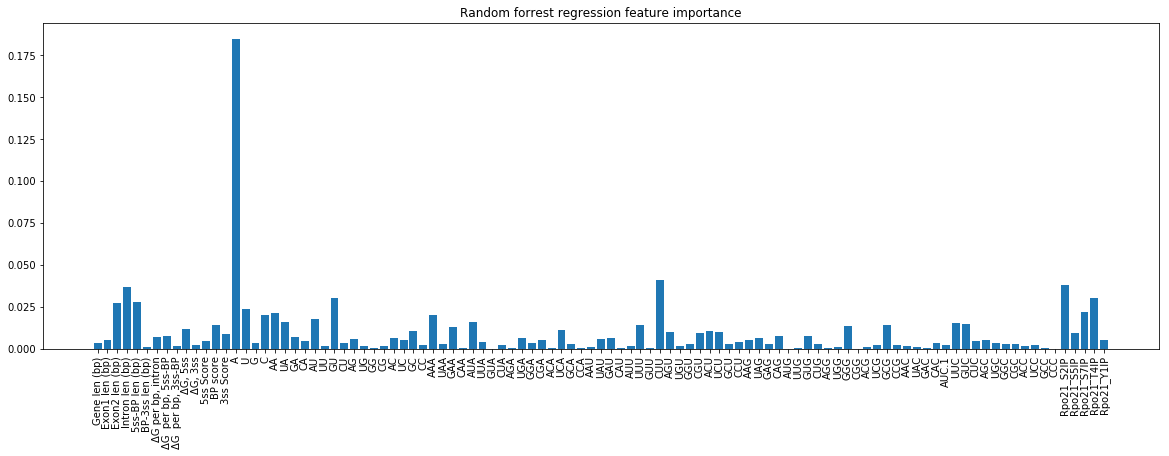

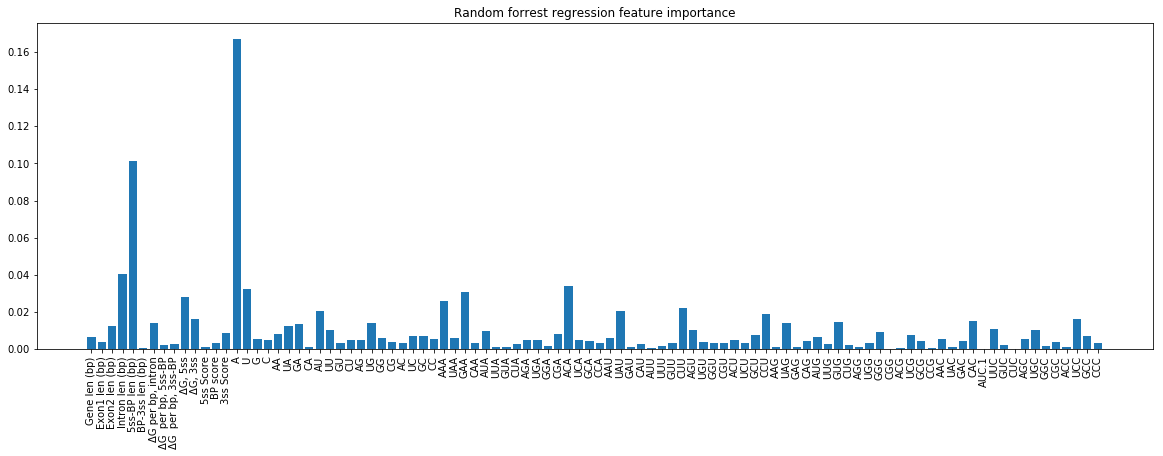

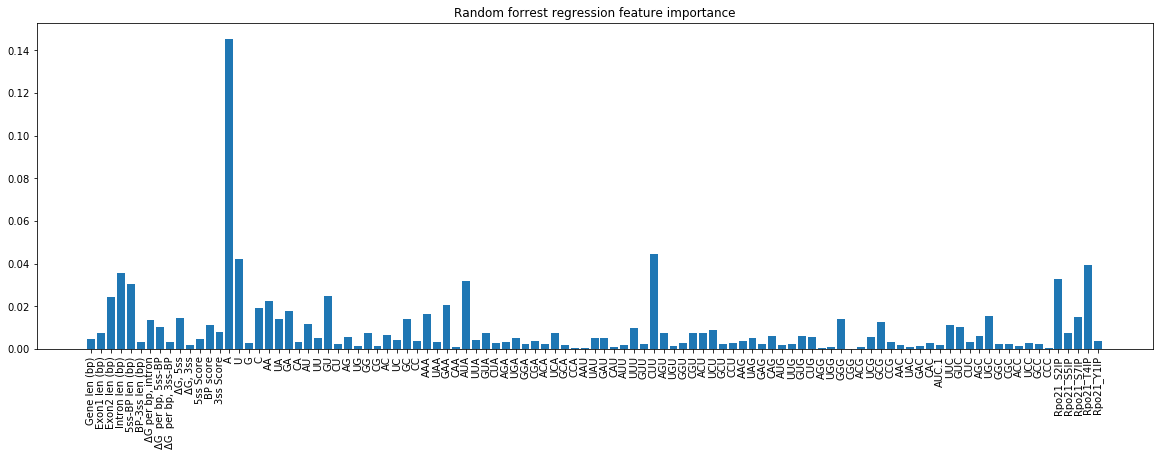

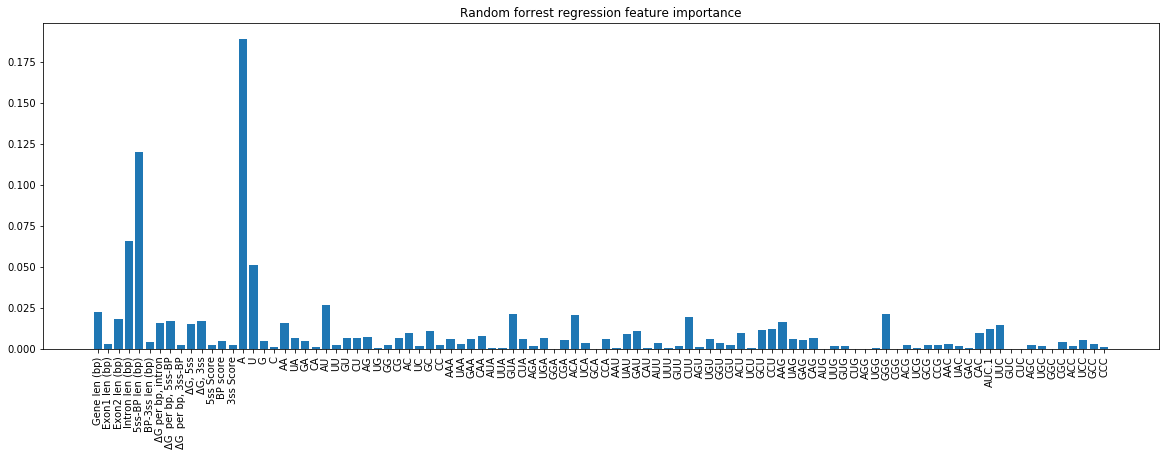

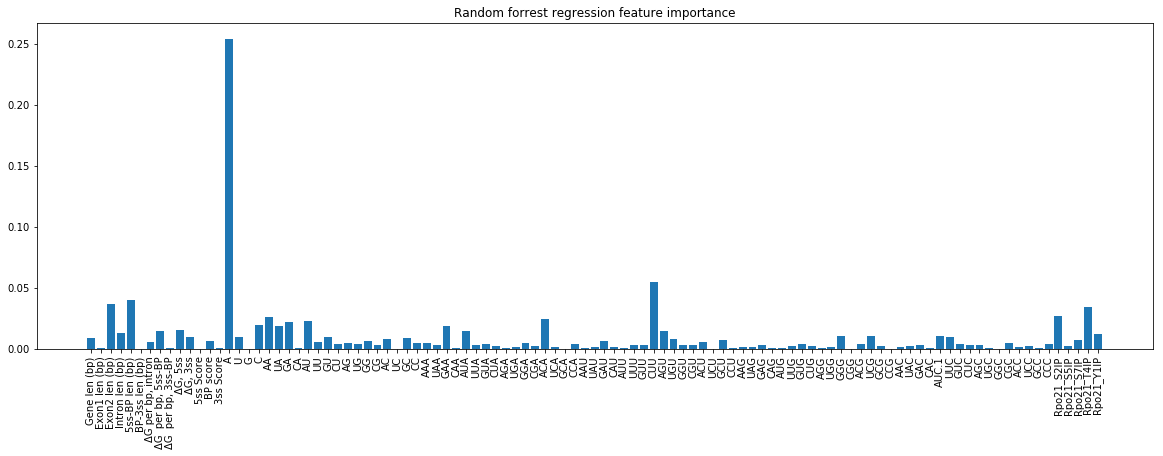

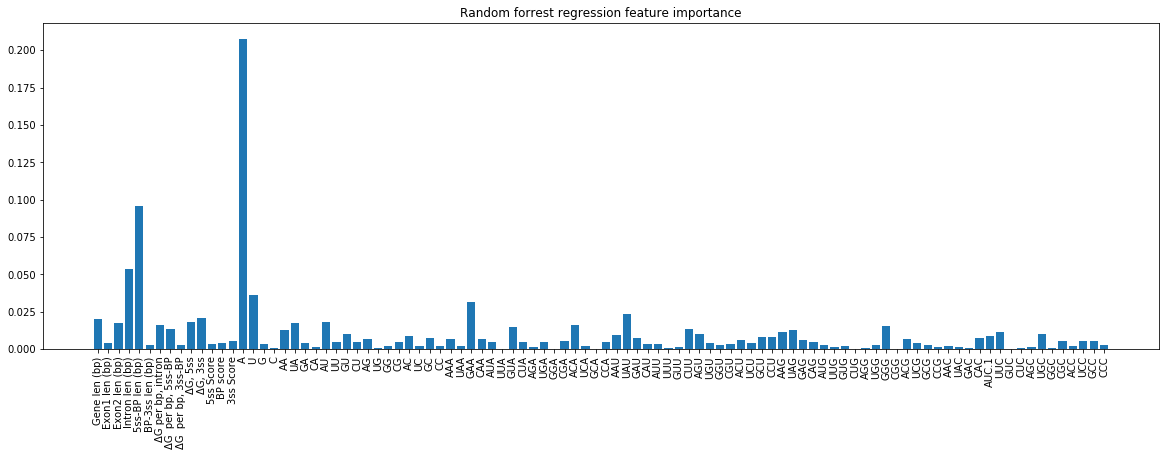

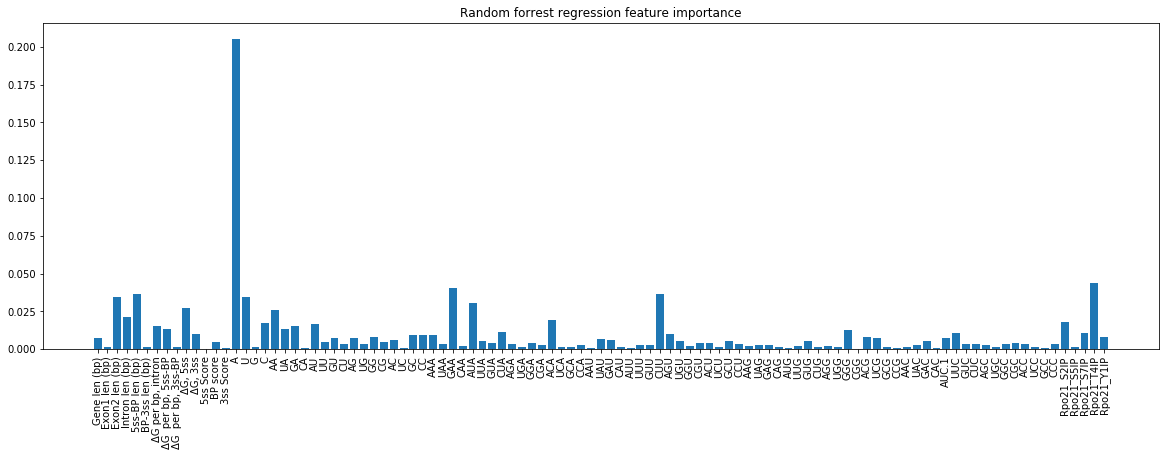

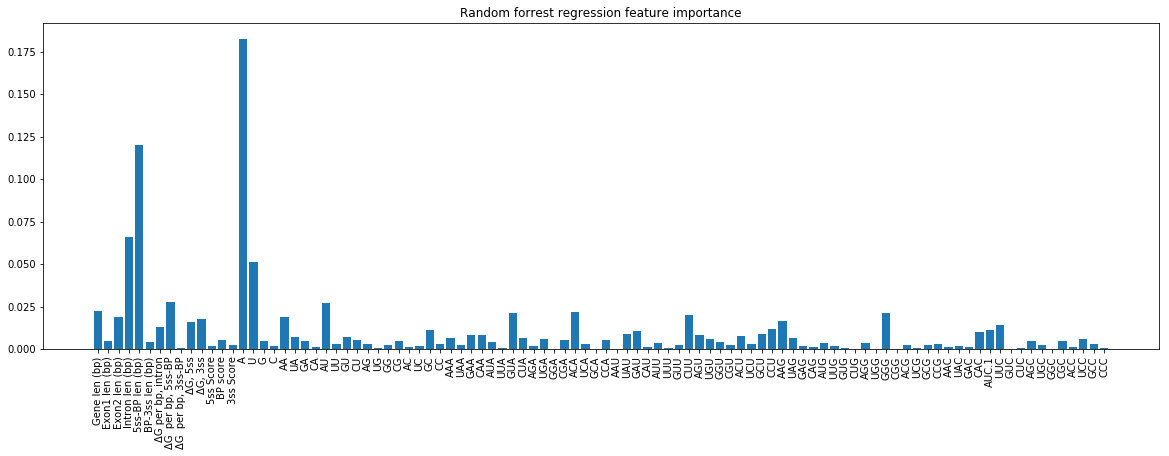

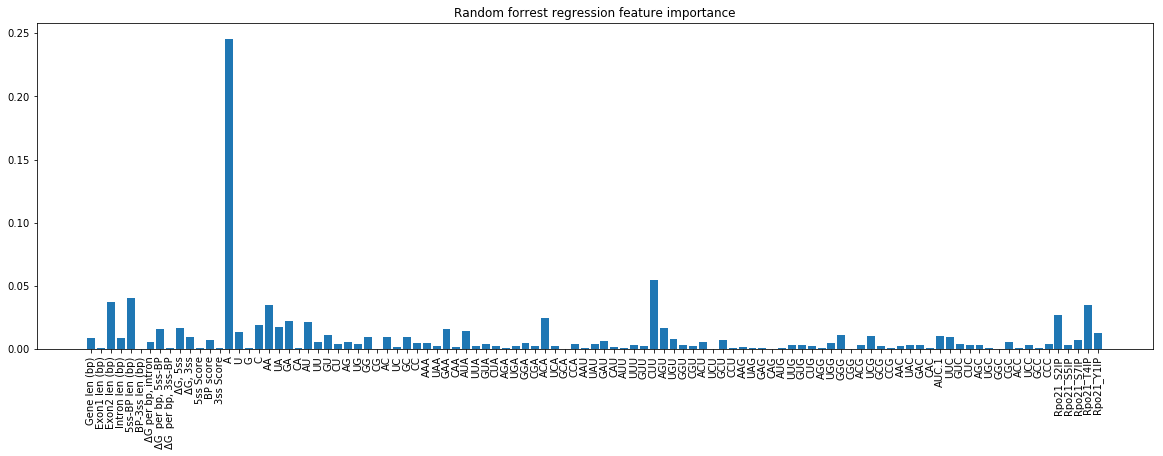

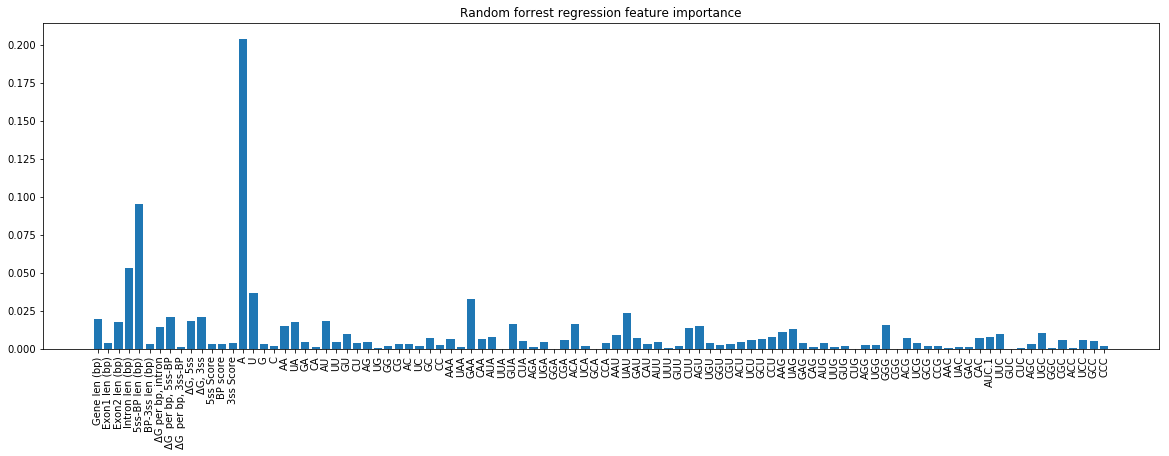

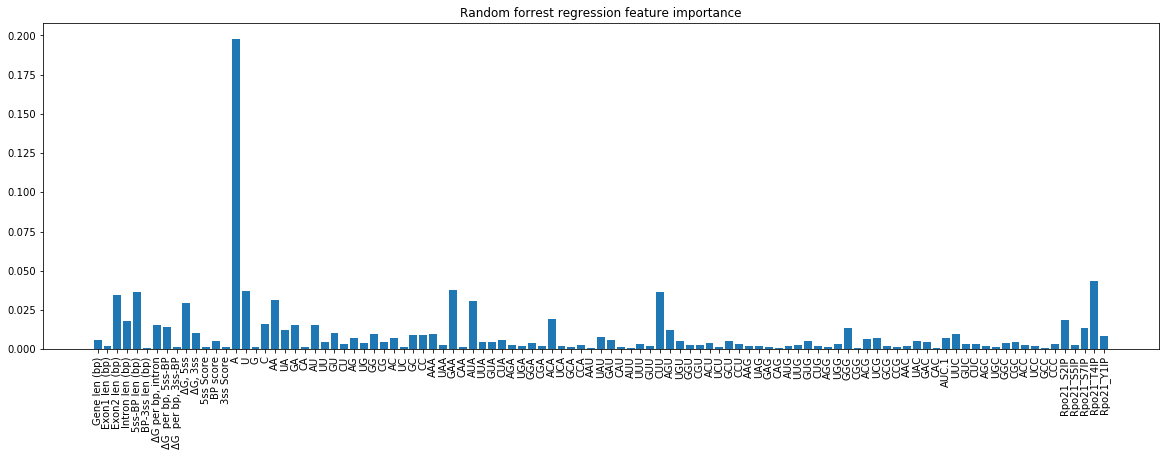

In [23]:
from ipywidgets import FloatProgress
from IPython.display import display

f = FloatProgress(min=0, max=1080)
display(f)

results_1 = np.zeros((12,10,9))
results_2 = np.zeros((12,10,9))
i = 0
for max_features in [25,50]:
    j = 0
    for max_depth in [10,15]:
        k = 0
        for n_estimators in [20,30]:
            
            
            kf = KFold(X.shape[0],n_folds=5,shuffle=True,random_state=0)

            rfr1 = RandomForestRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            rfr2 = RandomForestRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            predictions_rfr1 = cross_val_predict(rfr1,X,y=y,cv=kf)
            predictions_rfr2 = cross_val_predict(rfr2,X_extended,y=y_extended,cv=kf)
            
            print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features,max_depth,n_estimators))

            print('Normal feature space')
            print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr1)))
            print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr1)))
            print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr1)))
            print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr1))))
            print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr1)[0][1]))
            
            print('\n')
            print('Extended feature space')
            print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr2)))
            print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr2)))
            print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr2)))
            print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr2))))
            print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr2)[0][1]))
            print('-------------------------------------------------------\n')
            
            
#             results_1[i][j][k]=r2_score(y, predictions_rfr1)
#             results_2[i][j][k]=r2_score(y, predictions_rfr2)
            f.value += 1
            
#             k += 1
#         j += 1
#     i += 1
            rfr1.fit(X,y)
            fig, ax1 = plt.subplots(figsize=(20,6))
            xx = np.arange(len(rfr1.feature_importances_))
            ax1.bar(xx, rfr1.feature_importances_)
            ax1.set_xticks(xx)
            ax1.set_xticklabels(gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
            ax1.set_title('Random forrest regression feature importance')
#             fig.savefig('Features_importance.png')

            rfr2.fit(X_extended,y_extended)
            fig2, ax2 = plt.subplots(figsize=(20,6))
            xx = np.arange(len(rfr2.feature_importances_))
            ax2.bar(xx, rfr2.feature_importances_)
            ax2.set_xticks(xx)
            ax2.set_xticklabels(extended_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
            ax2.set_title('Random forrest regression feature importance')
#             fig2.savefig('Features_importance2.png')

# Lasso

In [7]:
kf = KFold(X.shape[0],n_folds=5,shuffle=True,random_state=0)

lrl1 = Lasso()

lrl2 = Lasso()

predictions_rfr1 = cross_val_predict(lrl1,X,y=y,cv=kf)
predictions_rfr2 = cross_val_predict(lrl2,X_extended,y=y_extended,cv=kf)

print('Normal feature space')
print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr1)))
print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr1)))
print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr1)))
print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr1))))
print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr1)[0][1]))

lrl1.fit(X,y)
# fig, ax1 = plt.subplots(figsize=(20,6))
# xx = np.arange(len(rfr1.feature_importances_))
# ax1.bar(xx, rfr1.feature_importances_)
# ax1.set_xticks(xx)
# ax1.set_xticklabels(gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
# ax1.set_title('Random forrest regression feature importance')
# fig.savefig('Features_importance.png')
print('\n')
print('Extended feature space')
print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr2)))
print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr2)))
print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr2)))
print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr2))))
print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr2)[0][1]))

lrl2.fit(X_extended,y_extended)
# fig2, ax2 = plt.subplots(figsize=(20,6))
# xx = np.arange(len(rfr2.feature_importances_))
# ax2.bar(xx, rfr2.feature_importances_)
# ax2.set_xticks(xx)
# ax2.set_xticklabels(extended_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
# ax2.set_title('Random forrest regression feature importance')
# fig2.savefig('Features_importance2.png')

Normal feature space
Coefficient of determination R^2: 0.3002059626406446
Mean squared error:               0.03649757178502856
Mean absolute error:              0.14752323421884786
Root mean squared error:          0.19104337671070556
Correlation Coefficient:          0.5485330662093058


Extended feature space
Coefficient of determination R^2: 0.3002059626406445
Mean squared error:               0.03649757178502857
Mean absolute error:              0.14752323421884786
Root mean squared error:          0.1910433767107056
Correlation Coefficient:          0.5485330662093056


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [12]:
kf = KFold(X.shape[0],n_folds=5,shuffle=True,random_state=0)

lrl1 = LassoCV(cv=3)

lrl2 = LassoCV(cv=3)

predictions_rfr1 = cross_val_predict(lrl1,X,y=y,cv=kf)
predictions_rfr2 = cross_val_predict(lrl2,X_extended,y=y_extended,cv=kf)

print('Normal feature space')
print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr1)))
print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr1)))
print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr1)))
print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr1))))
print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr1)[0][1]))

lrl1.fit(X,y)
# fig, ax1 = plt.subplots(figsize=(20,6))
# xx = np.arange(len(rfr1.feature_importances_))
# ax1.bar(xx, rfr1.feature_importances_)
# ax1.set_xticks(xx)
# ax1.set_xticklabels(gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
# ax1.set_title('Random forrest regression feature importance')
# fig.savefig('Features_importance.png')
print('\n')
print('Extended feature space')
print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr2)))
print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr2)))
print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr2)))
print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr2))))
print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr2)[0][1]))

lrl2.fit(X_extended,y_extended)
# fig2, ax2 = plt.subplots(figsize=(20,6))
# xx = np.arange(len(rfr2.feature_importances_))
# ax2.bar(xx, rfr2.feature_importances_)
# ax2.set_xticks(xx)
# ax2.set_xticklabels(extended_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
# ax2.set_title('Random forrest regression feature importance')
# fig2.savefig('Features_importance2.png')

Normal feature space
Coefficient of determination R^2: 0.26706300759348933
Mean squared error:               0.03822613378530802
Mean absolute error:              0.153336477372941
Root mean squared error:          0.19551504746517087
Correlation Coefficient:          0.5169765486985246


Extended feature space
Coefficient of determination R^2: 0.29285414262975407
Mean squared error:               0.03688100400118547
Mean absolute error:              0.14922460768060203
Root mean squared error:          0.192044276147938
Correlation Coefficient:          0.5463879572133933


LassoCV(alphas=None, copy_X=True, cv=3, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

Computing regularization path using the lasso...
Computing regularization path using the positive lasso...
Computing regularization path using the elastic net...
Computing regularization path using the positive elastic net...


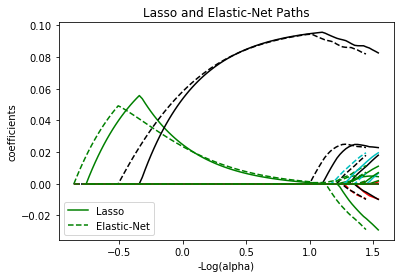

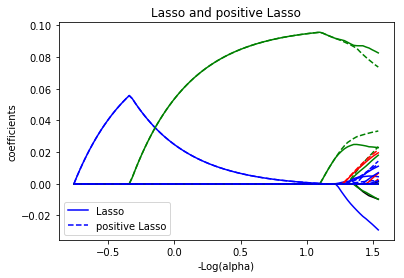

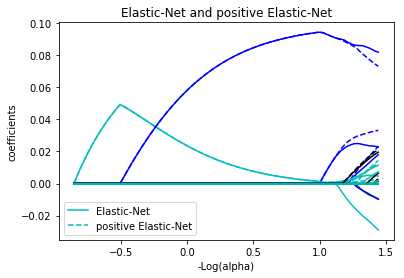

In [8]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets


X /= X.std(axis=0)  # Standardize data (easier to set the l1_ratio parameter)

# Compute paths

eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps, fit_intercept=False)

print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(
    X, y, eps, positive=True, fit_intercept=False)
print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, fit_intercept=False)

print("Computing regularization path using the positive elastic net...")
alphas_positive_enet, coefs_positive_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, positive=True, fit_intercept=False)

# Display results

plt.figure(1)
ax = plt.gca()

colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')


plt.figure(2)
ax = plt.gca()
neg_log_alphas_positive_lasso = -np.log10(alphas_positive_lasso)
for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_positive_lasso, coef_pl, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and positive Lasso')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'positive Lasso'), loc='lower left')
plt.axis('tight')


plt.figure(3)
ax = plt.gca()
neg_log_alphas_positive_enet = -np.log10(alphas_positive_enet)
for (coef_e, coef_pe, c) in zip(coefs_enet, coefs_positive_enet, colors):
    l1 = plt.plot(neg_log_alphas_enet, coef_e, c=c)
    l2 = plt.plot(neg_log_alphas_positive_enet, coef_pe, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic-Net and positive Elastic-Net')
plt.legend((l1[-1], l2[-1]), ('Elastic-Net', 'positive Elastic-Net'),
           loc='lower left')
plt.axis('tight')
plt.show()

In [4]:
# data_pca = pca.transform(data)
# y_true = digits.target

kf = KFold(X.shape[0],n_folds=5,shuffle=True,random_state=0)

svc_score_array = np.zeros((5,1));
svc_pca_score_array = np.zeros((5,1));
gaus_score_array = np.zeros((5,1));
gaus_pca_score_array = np.zeros((5,1));

i = 0;
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    X_train_pca, X_test_pca = X_extended[train_index], X_extended[test_index]
    
    y_train, y_test = y[train_index], y[test_index]

    svc_lin = SVC(kernel='linear',shrinking=False,random_state=1337)
    svc_lin.fit(X_train, y_train)

    svc_lin_pca = SVC(kernel='linear',shrinking=False,random_state=1337)
    svc_lin_pca.fit(X_train_pca, y_train)

    gaus = GaussianNB()
    gaus.fit(X_train,y_train)

    gaus_pca = GaussianNB()
    gaus_pca.fit(X_train_pca,y_train)


    svc_score_array[i] = svc_lin.score(X_test, y_test)
    svc_pca_score_array[i] = svc_lin_pca.score(X_test_pca, y_test)
    gaus_score_array[i] = gaus.score(X_test, y_test)
    gaus_pca_score_array[i] = gaus_pca.score(X_test_pca, y_test)

    i = i + 1;
    
svc_mean_performance = svc_score_array.mean(axis=0);
svc_pca_mean_performance = svc_pca_score_array.mean(axis=0);
gaus_mean_performance = gaus_score_array.mean(axis=0);
gaus_pca_mean_performance = gaus_pca_score_array.mean(axis=0);

print("Mean accuracy of SVC on digit data: {}".format(svc_mean_performance[0]))
print("Mean accuracy of SVC on pca transformed digit data: {}".format(svc_pca_mean_performance[0]))
print("Mean accuracy of SVC on digit data: {}".format(gaus_mean_performance[0]))
print("Mean accuracy of SVC on pca transformed digit data: {}".format(gaus_pca_mean_performance[0]))

KeyError: '[  2   7  10  13  16  22  24  26  43  50  59  61  62  73  74  86  91  93\n  94  95 101 108 112 116] not in index'

In [ ]:
kf = KFold(X.shape[0],n_folds=5,shuffle=True,random_state=0)

svc1 = SVR(kernel='poly',shrinking=False)
svc2 = SVR(kernel='poly',shrinking=False)

predictions_rfr1 = cross_val_predict(svc1,X,y=y,cv=kf)
predictions_rfr2 = cross_val_predict(svc2,X_extended,y=y_extended,cv=kf)

print('Normal feature space')
print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr1)))
print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr1)))
print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr1)))
print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr1))))
print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr1)[0][1]))

# rfr1.fit(X,y)
# fig, ax1 = plt.subplots(figsize=(20,6))
# xx = np.arange(len(rfr1.feature_importances_))
# ax1.bar(xx, rfr1.feature_importances_)
# ax1.set_xticks(xx)
# ax1.set_xticklabels(gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
# ax1.set_title('Random forrest regression feature importance')

print('\n')
print('Extended feature space')
print('Coefficient of determination R^2: {}'.format(r2_score(y, predictions_rfr2)))
print('Mean squared error:               {}'.format(mean_squared_error(y, predictions_rfr2)))
print('Mean absolute error:              {}'.format(mean_absolute_error(y, predictions_rfr2)))
print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(y, predictions_rfr2))))
print('Correlation Coefficient:          {}'.format(np.corrcoef(y, predictions_rfr2)[0][1]))

# rfr2.fit(X_extended,y_extended)
# fig2, ax2 = plt.subplots(figsize=(20,6))
# xx = np.arange(len(rfr2.feature_importances_))
# ax2.bar(xx, rfr2.feature_importances_)
# ax2.set_xticks(xx)
# ax2.set_xticklabels(extended_features.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
# ax2.set_title('Random forrest regression feature importance')